# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Оглавление
- [Общая информация](#general_info)
- [Предобработка данных](#pre_processing)
 - [Пропуски данных](#missing_data)
   - [Пропуски в данных добавленные пользователями](#users_missing_data)
   - [Пропуски в картографических данных](#cartographic_missing_data)
 - [Изменение типов данных](#types)
 - [Обработка дубликатов](#duplicates)
 - [Обработка аномалий](#anomalies)
- [Добавление новых стобцов](#new_columns)
- [Исследовательский анализ данных](#eda)
 - [Изучение имеющихся данных](#ed)
 - [Изучение скорости продаж квартир](#sale_speed)
 - [Факторы влияющие на стоимость объекта](#price_factors)
 - [Средняя цена кв.метра в самых распространённых пунктах](#avg_price_top_towns)
 - [Средняя цена километра (до центра) в Санкт-Петербурге](#avg_price_km)
- [Выводы](#conclusion) 

<a id='general_info'></a>
## Изучим общую информацию.

**Импортируем необходимые библиотеки**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

**Читаем исходный файл**

In [2]:
data = pd.read_csv('real_estate_data.csv', sep='\t')

original_data = data
# В данном файле формата csv данные разделены не запятой, а табуляцией.
# Указали в аргументе функции read_csv параметр sep='\t', для разделения колонок табуляцией

**Основная информация о датафрейме**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

- В данных находится 23699 строк (объекты недвижимости). 
- Бросается в глаза колонка `is_apartment`, в которой находится только 2775 строк и тип колонки object, хотя должен быть булев тип.
- Колонки `last_price`, `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition` имеют вещественный тип, а должны быть в целочисленном типе

**Первые 15 строк датасета**

In [4]:
pd.set_option('display.max_columns', 50)
data.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


- Вывели первые 15 строк, чтобы увидеть возможные ошибки в данных
- Видим что в колонке `is_apartment` в строке где нет пропуска указано значение в булевом типе. В дальнейшем нужно тщательнее проанализировать данный столбец
- Колонки `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest` содержат значения расстояния в метрах, но мы видим что данные тут должны быть в целочисленном типе, а не в вещественном
- Время в колонке `first_day_exposition` указано в формате ISO. Видим только даты, время везде указано 00:00:00, видимо округлены до дня.

**Строим простые гистограммы для всех колонок**

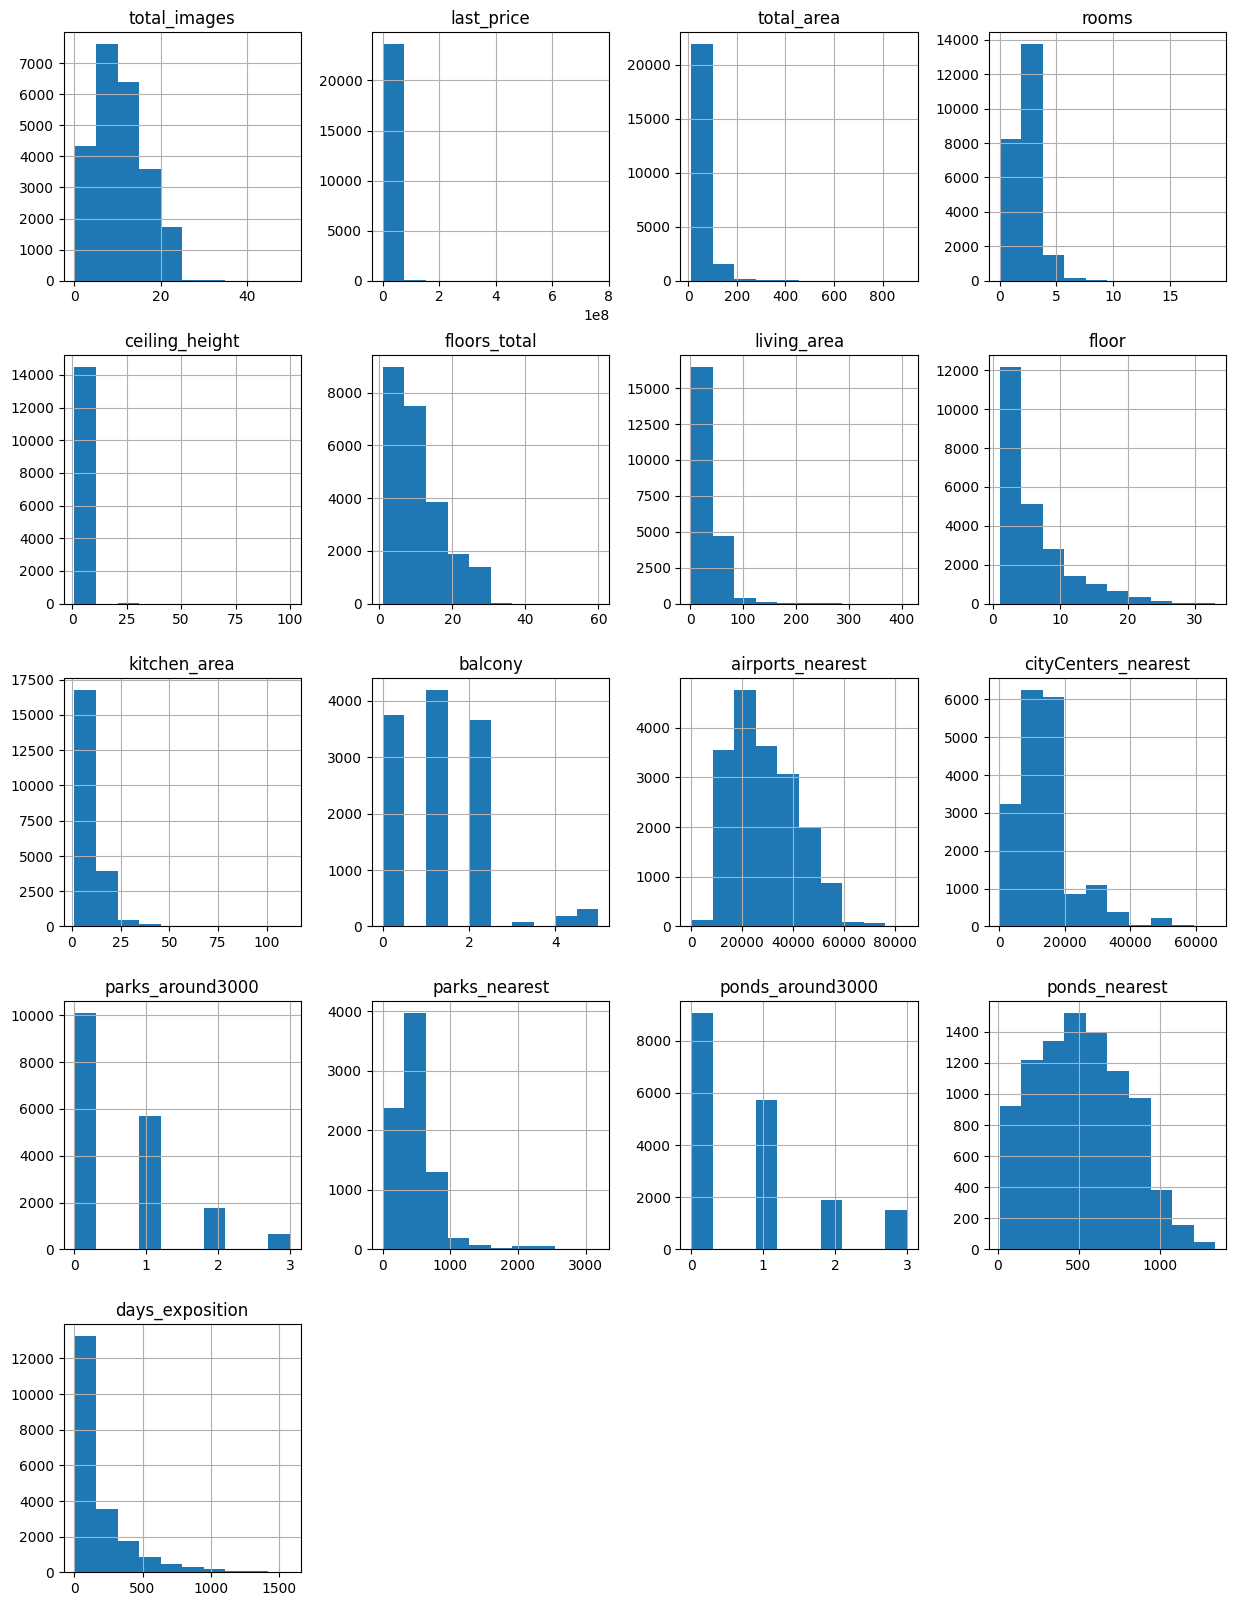

In [5]:
data.hist(figsize=(15, 20));

Каких-то выделяющихся аномалий по этим гистограмам не видно.

<a id='pre_processing'></a>
## Предобработка данных

<a id='missing_data'></a>
### Пропуски данных 

<a id='users_missing_data'></a>
#### Пропуски в данных добавленные пользователями

**Выведем сумму пропусков в каждой колонке**

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

- В колонке с количеством этажей в доме мало пропусков и нет возможности их востановить. Данные строки можно удалить, это не должно повлиять на исследование.
- В колонке с назвнием населенного пункта похожая ситуация. Нет возможности узнать название и соответсвеннно нет смысла оставлять эти данные.

In [7]:
data = data.dropna(subset=['floors_total', 'locality_name']).reset_index(drop=True)

**Выведем сумму пропусков опять, чтобы убедится в удалении ненужных строк.**

In [8]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9084
floors_total                0
living_area              1865
floor                       0
is_apartment            20805
studio                      0
open_plan                   0
kitchen_area             2222
balcony                 11475
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Теперь проверим столбец `is_apartment`, в нём больше всего пропусков.

In [9]:
print(data['is_apartment'].value_counts())
print(data['is_apartment'].unique())

False    2710
True       50
Name: is_apartment, dtype: int64
[nan False True]


Видим что в данной колонке только два значения (True, False) и пропуски в виде nan. Можем принять эти пропуски как то что это не апартаменты (False).

In [10]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Проверим теперь как выглядит столбец

In [11]:
data['is_apartment'].value_counts()

False    23515
True        50
Name: is_apartment, dtype: int64

Проверим столбец balcony

In [12]:
print(data['balcony'].value_counts())
print(data['balcony'].unique())

1.0    4187
0.0    3680
2.0    3656
5.0     304
4.0     182
3.0      81
Name: balcony, dtype: int64
[nan  2.  0.  1.  5.  4.  3.]


Скорей всего пропуски в данном случае значат что балкон отсутствует. Заменим пропуски на 0

In [13]:
data['balcony'] = data['balcony'].fillna(0)

Проверим теперь как выглядит столбец

In [14]:
data['balcony'].value_counts()

0.0    15155
1.0     4187
2.0     3656
5.0      304
4.0      182
3.0       81
Name: balcony, dtype: int64

Посмотрим какие значения находятся в колонке `ceiling_height`

In [15]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

Пропуски в данном столбце мы можем заполнить медианой. А так же нужно разобраться с выбивающимися значениями. Всё что больше 10м скорей всего неправильно записаны и подразумеваются 1.0м и тд. А так-же у нас есть значения меньше 2м, расмотрим их на этапе обработки аномалий.

Посмотрим на значения методом describe.

In [16]:
data['ceiling_height'].describe()

count    14481.000000
mean         2.771283
std          1.261983
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Медиана 2,65м что является нормальным значением. для данного параметра. Первый и третий квартиль тоже выглядят нормально. Выбиваются минимальные и максимальные значения. Можем заполнить пропуски медианой. А выбивающимися значениями позже займёмся

In [17]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

Выведем сумму пропусков по колонкам чтобы проверить что нам ещё надо обработать.

In [18]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area              1865
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2222
balcony                     0
locality_name               0
airports_nearest         5524
cityCenters_nearest      5501
parks_around3000         5500
parks_nearest           15535
ponds_around3000         5500
ponds_nearest           14529
days_exposition          3171
dtype: int64

Посмотрим на жилую площать и площать кухни

In [19]:
data['living_area'].describe()

count    21700.000000
mean        34.454822
std         22.045359
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [20]:
data['kitchen_area'].describe()

count    21343.000000
mean        10.560994
std          5.900630
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Можно было бы заполнить пропуски медианным значением, но в данном случае строки лучше просто удалить. Данные парамеры могут сильно отличатся и заполнение медианой или средним не выглядят рациональным способом.

In [21]:
data = data.dropna(subset=['living_area', 'kitchen_area']).reset_index(drop=True)

In [22]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4665
cityCenters_nearest      4644
parks_around3000         4643
parks_nearest           13664
ponds_around3000         4643
ponds_nearest           12846
days_exposition          2885
dtype: int64

**Промежуточный вывод по пропускам**

Разобрались с пропусками по данным которые добавлены пользователями.
- От строк где отсутвовало название населённого пункта избавились. Их было крайне мало, поэтому это не повлияет на исследование. Они могли появится из-за того что пользователь не указал его.
- Пропуски связанные с количеством этажей удалили. Этих значений тоже было очень мало.
- В строках где отсутвоввало колличество балконов мы приняли пропуски за отсутсвие балкона. Такие пропуски могли быть из-за разницы форм которые пользователь заполнял и при отсутсвии балкона он ставил не 0, как другие пользователи.
- Строки с пропущенными площадями жилой площади и кухни удалили, так как не было возможности адекватно заменить их.
- Пропуски связанные с высотой потолков заполнили медианой.
- Пропуски в колонке с апартаментами приняли за отрицание (False). Так же как и с балконами, такие пропуски из-за разных форм или неправильности их заполнения могли появится.

<a id='cartographic_missing_data'></a>
#### Пропуски в картографических данных

Растояние до аэропорта мы можем заполнить медианой по населённым пунктам. Выведем медиану и среднее значение.

In [23]:
data.pivot_table(index='locality_name', values='airports_nearest', aggfunc=['median', 'mean'])

,median,mean
,airports_nearest,airports_nearest
locality_name,,
Зеленогорск,72280.0,73296.304348
Колпино,26232.0,26373.869159
Красное Село,25715.5,26498.567901
Кронштадт,67844.0,67452.488636
Ломоносов,48406.0,48290.317073
Павловск,20502.0,20989.428571
Петергоф,39254.0,40267.536842
Пушкин,15745.0,16454.611276


Медиана и среднее везде практически одинаковые, значит выбросы или отсутсвуют или их количество незначительно. Но очень мало значений в сводной таблице сгрупперованной по колонке `locality_name`.

Изучим растояние до аэропорта методом describe и построим гистограмму

In [24]:
data['airports_nearest'].describe()

count    16240.000000
mean     28790.589963
std      12653.955431
min          0.000000
25%      18518.000000
50%      26729.000000
75%      37228.000000
max      84869.000000
Name: airports_nearest, dtype: float64

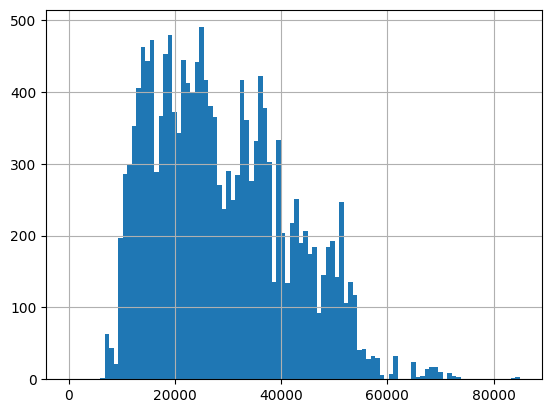

In [25]:
data['airports_nearest'].hist(bins=100);

Данные выглядят логично, только минимальное значение 0 выбивается на общем фоне. Перед тем как заполнять пропуски медианой, нужно рассмотреть эти 0 значения

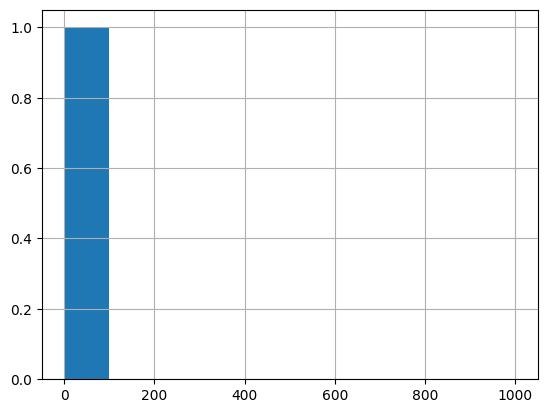

In [26]:
data['airports_nearest'].hist(range=(0, 1000));

Видим что 0 у нас только один, можем удалить это значение

In [27]:
data = data[~data["airports_nearest"].isin([0])]

Посмотрим теперь на данные по этому столбцу

In [28]:
data['airports_nearest'].describe()

count    16239.000000
mean     28792.362892
std      12652.327813
min       6450.000000
25%      18520.000000
50%      26729.000000
75%      37228.000000
max      84869.000000
Name: airports_nearest, dtype: float64

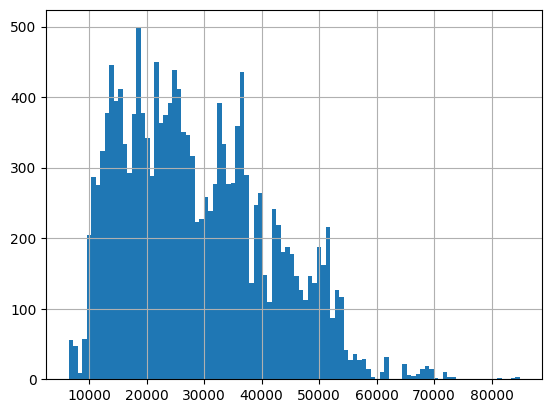

In [29]:
data['airports_nearest'].hist(bins=100);

До этого обнаружили при группировке медиан по населённым пунктам что мы получили значения для малого количества населённых пунктов.

Проверим сколько уникальных значений в этой колонке

In [30]:
len(data['locality_name'].unique())

345

Есть подозрение что данные по растоянию до аэропорта есть только у малого количества населённых пунктов, проверим это.

In [31]:
data.groupby('locality_name')['airports_nearest'].median().isna().sum()

# Сгруппировали данные по столбцу locality_name и посчитали медиану для каждого населённого пункта.
# После этого посчитали количество пропусков в тех населённых пунктах где одни пропуски.
# Так мы получили количество населённых пунктов где данные о растоянии до аэропорта отсутсвуют

321

У нас есть данные только для 24 населённых пунктов по аэропортам. Те данные что у нас есть распределены адекватно. Удалять данные с пропусками в данном случае нежелательно, лучше их оставить.

Посмотрим на растояние центра города. Видим что там примерно такое же количество пропусков и эти данные были так-же автоматически собраны, поэтому есть подозрение что тут похожая ситуация как и в случаи с растоянием до аэропорта. Выведем медианы и средние значения, сгрупированные по населённым пунктам.

In [32]:
data.pivot_table(index='locality_name', values='cityCenters_nearest', aggfunc=['median', 'mean'])

,median,mean
,cityCenters_nearest,cityCenters_nearest
locality_name,,
Зеленогорск,53379.0,54623.130435
Колпино,32018.0,32122.049844
Красное Село,29140.5,29923.277778
Кронштадт,49570.0,49179.011364
Ломоносов,51677.0,50770.317073
Павловск,32655.0,33143.028571
Петергоф,33771.0,35510.889474
Пушкин,27909.0,28766.535714


Как и прошлый раз видим мало значений, но те которые есть распределены корректно. Посмотрим на распределение и гистограмму.

In [33]:
data['cityCenters_nearest'].describe()

count    16260.000000
mean     14246.604367
std       8670.030454
min        181.000000
25%       9350.000000
50%      13114.000000
75%      16254.750000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

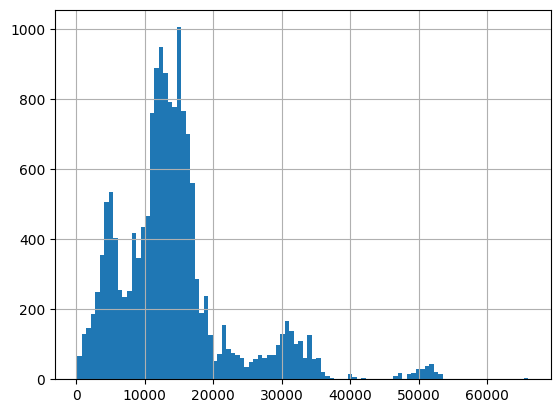

In [34]:
data['cityCenters_nearest'].hist(bins=100);

Выглядит логично. Посмотрим как и в прошлый раз количество населённых пунктов где значения отсутсвуют.

In [35]:
data.groupby('locality_name')['cityCenters_nearest'].median().isna().sum()

321

Ситуация такая-же, пропуски оставляем.

Есть подозрение что подобное мы увидим в остальных данных собраных автоматически. Проверим сразу расстояния до парка и водоёма, а также их количество, так же как делали проверку до этого 

In [36]:
data.pivot_table(index='locality_name', values=['parks_nearest', 'ponds_nearest'], aggfunc=['median', 'mean'])

median                        mean  \
                        parks_nearest ponds_nearest parks_nearest   
locality_name                                                       
Зеленогорск                     148.0         507.0    224.400000   
Колпино                         393.0         505.0    490.629921   
Красное Село                    439.0         225.5    474.075000   
Кронштадт                       312.0         317.0    325.426829   
Ломоносов                       407.0         574.5    363.333333   
Павловск                        312.0         471.5    375.958333   
Петергоф                        294.0         488.5    418.088889   
Пушкин                          395.0         420.5    398.796954   
Санкт-Петербург                 460.0         505.0    495.762431   
Сестрорецк                      367.0         372.0    415.439394   
посёлок Александровская           NaN         711.5           NaN   
посёлок Белоостров                NaN         320.0           NaN   
посёлок Парголово               733.0         593.0    521.250000   
посёлок Понтонный                 NaN         485.0           NaN   
посёлок Сапёрный                  NaN         419.5           NaN   
посёлок Стрельна                700.0         859.0    580.157895   
посёлок Шушары                    NaN         594.0           NaN   

                                       
                        ponds_nearest  
locality_name                          
Зеленогорск                501.705882  
Колпино                    532.494505  
Красное Село               445.500000  
Кронштадт                  357.111111  
Ломоносов                  559.723684  
Павловск                   503.500000  
Петергоф                   522.821429  
Пушкин                     468.432927  
Санкт-Петербург            521.829449  
Сестрорецк                 405.328000  
посёлок Александровская    711.500000  
посёлок Белоостров         320.000000  
посёлок Парголово          602.588235  
посёлок Понтонный          514.800000  
посёлок Сапёрный           426.833333  
посёлок Стрельна           741.875000  
посёлок Шушары             566.762963

In [37]:
data.pivot_table(index='locality_name', values=['parks_around3000', 'ponds_around3000'], aggfunc=['median', 'mean'])

median                              mean  \
                        parks_around3000 ponds_around3000 parks_around3000   
locality_name                                                                
Зеленогорск                          3.0              1.0         1.869565   
Колпино                              0.0              1.0         0.529595   
Красное Село                         0.0              0.0         0.462963   
Кронштадт                            2.0              2.0         1.784091   
Ломоносов                            0.0              1.0         0.195122   
Павловск                             2.0              2.0         1.571429   
Петергоф                             1.0              1.0         1.321053   
Пушкин                               1.0              0.0         0.768546   
Санкт-Петербург                      0.0              1.0         0.627171   
Сестрорецк                           0.0              1.0         0.602410   
поселок Лисий Нос                    0.0              0.0         0.000000   
посёлок Александровская              0.0              1.0         0.000000   
посёлок Белоостров                   0.0              1.0         0.000000   
посёлок Лисий Нос                    0.0              0.0         0.000000   
посёлок Металлострой                 0.0              0.0         0.000000   
посёлок Молодёжное                   0.0              0.0         0.000000   
посёлок Парголово                    0.0              0.0         0.027778   
посёлок Песочный                     0.0              0.0         0.000000   
посёлок Понтонный                    0.0              0.0         0.000000   
посёлок Репино                       0.0              0.0         0.000000   
посёлок Сапёрный                     0.0              1.0         0.000000   
посёлок Стрельна                     0.0              1.0         0.720930   
посёлок Усть-Ижора                   0.0              0.0         0.000000   
посёлок Шушары                       0.0              0.0         0.000000   

                                          
                        ponds_around3000  
locality_name                             
Зеленогорск                     0.869565  
Колпино                         1.006231  
Красное Село                    0.098765  
Кронштадт                       1.943182  
Ломоносов                       1.081301  
Павловск                        1.857143  
Петергоф                        1.310526  
Пушкин                          0.905045  
Санкт-Петербург                 0.760809  
Сестрорецк                      1.210843  
поселок Лисий Нос               0.000000  
посёлок Александровская         1.000000  
посёлок Белоостров              1.000000  
посёлок Лисий Нос               0.000000  
посёлок Металлострой            0.000000  
посёлок Молодёжное              0.000000  
посёлок Парголово               0.305556  
посёлок Песочный                0.000000  
посёлок Понтонный               0.312500  
посёлок Репино                  0.000000  
посёлок Сапёрный                1.000000  
посёлок Стрельна                1.069767  
посёлок Усть-Ижора              0.000000  
посёлок Шушары                  0.345269

In [38]:
data['parks_nearest'].describe()

count    7241.000000
mean      487.876260
std       337.722337
min         1.000000
25%       287.000000
50%       453.000000
75%       610.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [39]:
data['ponds_nearest'].describe()

count    8059.000000
mean      519.548331
std       277.570489
min        13.000000
25%       294.500000
50%       503.000000
75%       733.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

In [40]:
data['parks_around3000'].describe()

count    16261.000000
mean         0.611832
std          0.801286
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [41]:
data['ponds_around3000'].describe()

count    16261.000000
mean         0.763299
std          0.937924
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

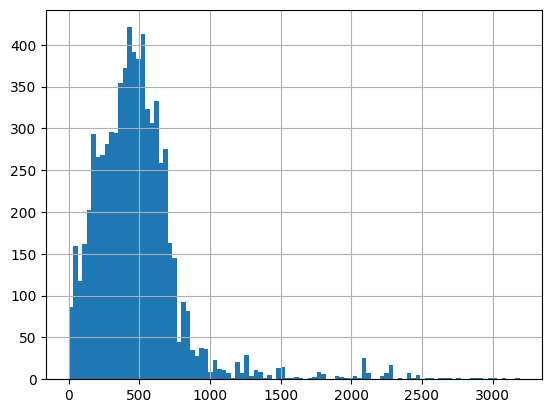

In [42]:
data['parks_nearest'].hist(bins=100);

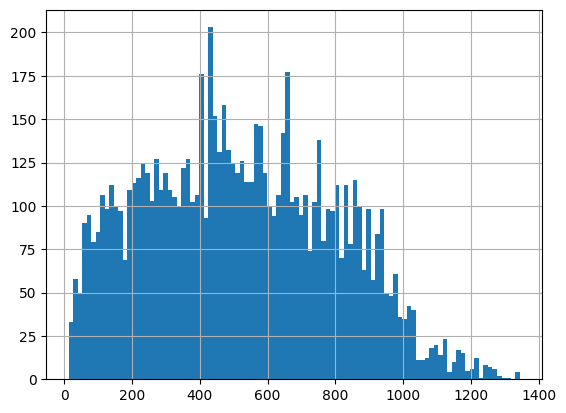

In [43]:
data['ponds_nearest'].hist(bins=100);

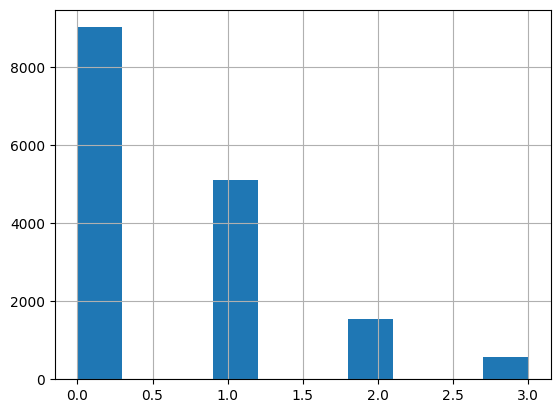

In [44]:
data['parks_around3000'].hist(bins=10);

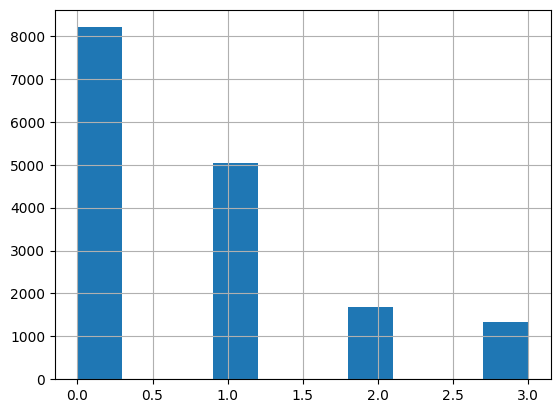

In [45]:
data['ponds_around3000'].hist(bins=10);

In [46]:
data.groupby('locality_name')['parks_nearest'].median().isna().sum()

333

In [47]:
data.groupby('locality_name')['ponds_nearest'].median().isna().sum()

328

Случаи с пропусками растояния игнорируем, а количество парков и водоёмов можем заполнить нулями, подразумевая отсутсвие значения как отсутсвие парка и водоёма.

In [48]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Так же проигнорируем пропуски в этих колонках.

Теперь осталось посмотреть на пропуски в days_exposition. Пропуски в данной колонке могут значит что обьявление на было снято и всё ещё активно. Удалять их не будем.

Посмотрим как теперь выглядит общая информация по датафрему и количество пропусков по колонкам.

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20904 entries, 0 to 20904
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          20904 non-null  int64  
 1   last_price            20904 non-null  float64
 2   total_area            20904 non-null  float64
 3   first_day_exposition  20904 non-null  object 
 4   rooms                 20904 non-null  int64  
 5   ceiling_height        20904 non-null  float64
 6   floors_total          20904 non-null  float64
 7   living_area           20904 non-null  float64
 8   floor                 20904 non-null  int64  
 9   is_apartment          20904 non-null  bool   
 10  studio                20904 non-null  bool   
 11  open_plan             20904 non-null  bool   
 12  kitchen_area          20904 non-null  float64
 13  balcony               20904 non-null  float64
 14  locality_name         20904 non-null  object 
 15  airports_nearest   

In [50]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4665
cityCenters_nearest      4644
parks_around3000            0
parks_nearest           13663
ponds_around3000            0
ponds_nearest           12845
days_exposition          2885
dtype: int64

**Вывод по пропускам данных**

Закончили разбор пропусков, по итогу от около 2500 строк пришлось избавится. В остальных случаях произвели заполнение наиболее логичным значеним для каждого из случаев, кроме нескольких колонок где пришлось оставить пропуски.
- Колонки airports_nearest, cityCenters_nearest, parks_around3000, ponds_around3000 оставили с пропусками, так как данные в основном отсутвовали полностью по большинству населённых пунктов, а там где они есть, распределены на первый взгляд корректно, поиском аномалий будем заниматься позже.
- В колонке days_exposition пропуски вероятней всего означают что объявление не было снято, поэтому их оставили в данных за неимением варианта адекватно их заменить.

Выводы по данным внесённых пользователем находятся в промежуточном выводе, до начала работы с картографическими пропусками.

<a id='types'></a>
### Изменение типов данных

В колонках `last_price`, `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000` должен быть целочисленный тип. Произведём замену. Колонку first_day_exposition переведём в формат datetime работающий с датой и временем

In [51]:
data['last_price'] = data['last_price'].astype('int64')
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data['parks_around3000'] = data['parks_around3000'].astype('int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('int64')
data['total_area'] = data['total_area'].astype('int64')
data['living_area'] = data['living_area'].astype('int64')
data['kitchen_area'] = data['kitchen_area'].astype('int64')

In [52]:
data['ceiling_height'] = data['ceiling_height'].astype('float32')
data['airports_nearest'] = data['airports_nearest'].astype('float32')
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('float32')
data['parks_nearest'] = data['parks_nearest'].astype('float32')
data['ponds_nearest'] = data['ponds_nearest'].astype('float32')
data['days_exposition'] = data['days_exposition'].astype('float32')

In [53]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M:%S')

Выведем первые 10 строк, чтобы посмотреть как теперь выглядят данные.

In [54]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108,2019-03-07,3,2.70,16,51,8,False,False,False,25,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40,2018-12-04,1,2.65,11,18,1,False,False,False,11,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56,2015-08-20,2,2.65,5,34,4,False,False,False,8,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,2,10000000,100,2018-06-19,2,3.03,14,32,13,False,False,False,41,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121.0
4,10,2890000,30,2018-09-10,1,2.65,12,14,5,False,False,False,9,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55.0
5,6,3700000,37,2017-11-02,1,2.65,26,10,6,False,False,False,14,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155.0
6,20,2900000,33,2018-05-23,1,2.65,27,15,26,False,False,False,8,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189.0
7,18,5400000,61,2017-02-26,3,2.50,9,43,7,False,False,False,6,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289.0
8,5,5050000,39,2017-11-16,1,2.67,12,20,3,False,False,False,8,0,Санкт-Петербург,38357.0,13878.0,1,310.0,2,553.0,137.0
9,9,3300000,44,2018-08-27,2,2.65,5,31,4,False,False,False,6,1,Ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0


В информации по датафрейму посмотрим типы стобцов.

In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20904 entries, 0 to 20904
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20904 non-null  int64         
 1   last_price            20904 non-null  int64         
 2   total_area            20904 non-null  int64         
 3   first_day_exposition  20904 non-null  datetime64[ns]
 4   rooms                 20904 non-null  int64         
 5   ceiling_height        20904 non-null  float32       
 6   floors_total          20904 non-null  int64         
 7   living_area           20904 non-null  int64         
 8   floor                 20904 non-null  int64         
 9   is_apartment          20904 non-null  bool          
 10  studio                20904 non-null  bool          
 11  open_plan             20904 non-null  bool          
 12  kitchen_area          20904 non-null  int64         
 13  balcony         

**Выводы по изменению типов данных**

- В колонке `first_day_exposition` находится дата и время в формате ISO, изменили в формат datetime, для того чтобы можно было проводить операции связанные с датой.
- В колонках `last_price`, `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000` находились значения которые подразумевают целочисленный формат, произвели замену.
- В колонках `ceiling_height`, `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest`, `days_exposition` изменили тип данных с float64 на float32 для экономии памяти.
- В колонках где оставили пропуски тоже подразумеваются значения в целочисленном формате, но мы не можем произвести замену из-за наличия пропусков NaN, которые находятся в типе float. Мы можем производить расчёты с участием этих колонок, пропуски будут просто игнорироватся.

<a id='duplicates'></a>
### Обработка дубликатов

Для начала проверим что в данных нету явных дубликатов

In [56]:
data.duplicated().sum()

0

Явных дубликатов нет. Теперь будем смотреть есть ли неявные дубликаты в населённых пунктах. Для начала приведём все значения к одному регистру, так как могут быть записаны в разных регистрах одни и те-же названия, потом выведем список с уникальными названиями.

In [57]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'].unique()

array(['санкт-петербург', 'посёлок шушары', 'городской посёлок янино-1',
       'посёлок парголово', 'посёлок мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'деревня кудрово', 'колпино', 'гатчина',
       'поселок мурино', 'деревня фёдоровское', 'выборг', 'кронштадт',
       'кировск', 'деревня новое девяткино', 'посёлок металлострой',
       'посёлок городского типа лебяжье',
       'посёлок городского типа сиверский', 'поселок молодцово',
       'поселок городского типа кузьмоловский',
       'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'посёлок аннино',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'посёлок понтонный', 'деревня старая',
       'деревня лесколово', 'село путилово', 'ивангород', 'мурино',
       'сланцы', 'шлиссельбург', 'сясьстрой', 'никольское', 'зеленогорск',
       'сосновый бор',

Напишем функцию для замены неявных дубликатов

In [58]:
def replace_names(wrong_name, right_name):
    for wrong_name in wrong_name:
        data['locality_name'] = data['locality_name'].replace(wrong_name, right_name)

Теперь соберём данные для использования этой функция. Создадим списки с дубликатами которые мы будем передавать функции в аргументе wrong_name и заменим на значения которые предварительно поместим в переменные которые передадим в аргументе right_name.

In [59]:
yanino_wrong = ['городской посёлок янино-1', 'городской поселок янино-1']
yanino_right = 'янино-1'
murino_wrong = ['посёлок мурино', 'поселок мурино']
murino_right = 'мурино'
kudrovo_wrong = ['деревня кудрово']
kudrovo_right = 'кудрово'
fedorovskoe_wrong = ['деревня фёдоровское', 'городской посёлок фёдоровское']
fedorovskoe_right = 'фёдоровское'
lebyajie_wrong = ['посёлок городского типа лебяжье', 'поселок городского типа лебяжье']
lebyajie_right = 'лебяжье'
kuzmolovskie_wrong = ['поселок городского типа кузьмоловский', 'посёлок городского типа кузьмоловский']
kuzmolovskie_right = 'кузьмоловский'
pavlovo_wrong = ['село павлово', 'городской посёлок павлово', 'посёлок городского типа павлово']
pavlovo_right = 'павлово'
annino_wrong = ['посёлок аннино', 'поселок аннино']
annino_right = 'аннино'
nikolskoe_wrong = ['село никольское']
nikolskoe_right = 'никольское'
novi_svet_wrong = ['поселок новый свет', 'посёлок новый свет']
novi_svet_right = 'новый свет'
bugri_wrong = ['посёлок бугры', 'поселок бугры']
bugri_right = 'бугры'
roshino_wrong = ['поселок городского типа рощино', 'посёлок городского типа рощино', 'городской посёлок рощино']
roshino_right = 'рощино'
ust_luga_wrong = ['посёлок усть-луга', 'поселок усть-луга']
ust_luga_right = 'усть-луга'
krasni_bor_wrong = ['посёлок городского типа красный бор', 'поселок городского типа красный бор']
krasni_bor_right = 'красный бор'
kommunar_wrong = ['поселок коммунары']
kommunar_right = 'коммунар'
tervolovo_wrong = ['поселок терволово', 'посёлок терволово']
tervolovo_right = 'терволово'
sovetski_wrong = ['поселок городского типа советский', 'городской посёлок советский']
sovetski_right = 'советский'
petrovskoe_wrong = ['посёлок петровское', 'поселок петровское']
petrovskoe_right = 'петровское'
toksovo_wrong = ['посёлок городского типа токсово', 'поселок городского типа токсово']
toksovo_right = 'токсово'
vyritsa_wrong = ['посёлок городского типа вырица', 'поселок городского типа вырица']
vyritsa_right = 'вырица'
luban_wrong = ['поселок любань']
luban_right = 'любань'
telmana_wrong = ['поселок тельмана']
telmana_right = 'посёлок тельмана'
bolshaya_izhora_wrong = ['городской поселок большая ижора', 'поселок городского типа большая ижора']
bolshaya_izhora_right = 'большая ижора'
rakhya_wrong = ['поселок городского типа рахья', 'садовое товарищество рахья']
rakhya_right = 'рахья'
sverdlova_wrong = ['поселок городского типа имени свердлова', 'посёлок городского типа имени свердлова']
sverdlova_right = 'посёлок имени свердлова'
ryabovo_wrong = ['поселок рябово', 'поселок городского типа рябово', 'посёлок городского типа рябово']
ryabovo_right = 'рябово'
polyani_wrong = ['посёлок поляны', 'поселок поляны']
polyani_right = 'поляны'
mga_wrong = ['городской посёлок мга', 'посёлок городского типа мга']
mga_right = 'мга'
michurinskoe_wrong = ['посёлок мичуринское', 'поселок мичуринское']
michurinskoe_right = 'мичуринское'
ilichevo_wrong = ['поселок ильичёво', 'посёлок ильичёво']
ilichevo_right = 'ильичёво'
veshcevo_wrong = ['поселок станции вещево', 'посёлок при железнодорожной станции вещево']
veshcevo_right = 'вещево'
sumino_wrong = ['посёлок сумино', 'поселок сумино']
sumino_right = 'сумино'
priladozhsky_wrong = ['поселок городского типа приладожский', 'садовое товарищество приладожский']
priladozhsky_right = 'приладожский'
gavrilovo_wrong = ['посёлок гаврилово', 'поселок гаврилово']
gavrilovo_right = 'гаврилово'
rabititsi_wrong = ['деревня рабитицы', 'поселок рабитицы']
rabititsi_right = 'рабитицы'
naziya_wrong = ['городской посёлок назия', 'поселок городского типа назия']
naziya_right = 'назия'
staraya_maluksa_wrong = ['поселок старая малукса', 'посёлок старая малукса']
staraya_maluksa_right = 'старая малукса'
pobeda_wrong = ['поселок победа', 'посёлок победа']
pobeda_right = 'победа'
garbolovo_wrong = ['деревня гарболово', 'поселок гарболово']
garbolovo_right = 'гарболово'
privetninskoe_wrong = ['поселок станции приветнинское', 'посёлок при железнодорожной станции приветнинское']
privetninskoe_right = 'приветнинское'
melnikovo_wrong = ['поселок мельниково', 'посёлок мельниково']
melnikovo_right = 'мельниково'
steklyani_wrong = ['поселок стеклянный', 'посёлок стеклянный']
steklyani_right = 'стеклянный'
fornosovo_wrong = ['поселок городского типа форносово', 'посёлок городского типа форносово']
fornosovo_right = 'форносово'
vozrozhdenie_wrong = ['посёлок возрождение', 'поселок возрождение']
vozrozhdenie_right = 'возрождение'
lisy_nos_wrong = ['поселок лисий нос', 'посёлок лисий нос']
lisy_nos_right = 'лисий нос'
zhylgorodok_wrong = ['поселок жилгородок', 'посёлок жилгородок']
zhylgorodok_right = 'жилгородок'
lesogorsky_wrong = ['городской посёлок лесогорский', 'поселок городского типа лесогорский']
lesogorsky_right = 'лесогорский'
gromovo_wrong = ['посёлок станции громово', 'поселок громово']
gromovo_right = 'громово'
korobitsino_wrong = ['посёлок коробицыно', 'поселок коробицыно']
korobitsino_right = 'коробицыно'
kobralovo_wrong = ['посёлок кобралово', 'поселок кобралово']
kobralovo_right = 'кобралово'
lesnoe_wrong = ['поселок лесное', 'коттеджный посёлок лесное']
lesnoe_right = 'лесное'
perovo_wrong = ['поселок лесное', 'коттеджный посёлок лесное']
perovo_right = 'перово'
zeleny_bor_wrong = ['посёлок пансионат зелёный бор', 'поселок пансионат зелёный бор']
zeleny_bor_right = 'зелёный бор'

In [60]:
replace_names(yanino_wrong, yanino_right)
replace_names(murino_wrong , murino_right)
replace_names(kudrovo_wrong, kudrovo_right)
replace_names(fedorovskoe_wrong, fedorovskoe_right)
replace_names(lebyajie_wrong, lebyajie_right)
replace_names(kuzmolovskie_wrong, kuzmolovskie_right)
replace_names(pavlovo_wrong, pavlovo_right)
replace_names(annino_wrong, annino_right)
replace_names(nikolskoe_wrong, nikolskoe_right)
replace_names(novi_svet_wrong, novi_svet_right)
replace_names(bugri_wrong, bugri_right)
replace_names(roshino_wrong, roshino_right)
replace_names(ust_luga_wrong, ust_luga_right)
replace_names(krasni_bor_wrong, krasni_bor_right)
replace_names(kommunar_wrong, kommunar_right)
replace_names(tervolovo_wrong, tervolovo_right)
replace_names(sovetski_wrong, sovetski_right)
replace_names(petrovskoe_wrong, petrovskoe_right)
replace_names(toksovo_wrong, toksovo_right)
replace_names(vyritsa_wrong, vyritsa_right)
replace_names(luban_wrong, luban_right)
replace_names(telmana_wrong, telmana_right)
replace_names(bolshaya_izhora_wrong, bolshaya_izhora_right)
replace_names(rakhya_wrong, rakhya_right)
replace_names(sverdlova_wrong, sverdlova_right)
replace_names(ryabovo_wrong, ryabovo_right)
replace_names(polyani_wrong, polyani_right)
replace_names(mga_wrong, mga_right)
replace_names(michurinskoe_wrong, michurinskoe_right)
replace_names(ilichevo_wrong, ilichevo_right)
replace_names(veshcevo_wrong, veshcevo_right)
replace_names(sumino_wrong, sumino_right)
replace_names(priladozhsky_wrong, priladozhsky_right)
replace_names(gavrilovo_wrong, gavrilovo_right)
replace_names(rabititsi_wrong, rabititsi_right)
replace_names(naziya_wrong, naziya_right)
replace_names(staraya_maluksa_wrong, staraya_maluksa_right)
replace_names(pobeda_wrong, pobeda_right)
replace_names(garbolovo_wrong, garbolovo_right)
replace_names(privetninskoe_wrong, privetninskoe_right)
replace_names(melnikovo_wrong, melnikovo_right)
replace_names(steklyani_wrong, steklyani_right)
replace_names(fornosovo_wrong, fornosovo_right)
replace_names(vozrozhdenie_wrong, vozrozhdenie_right)
replace_names(lisy_nos_wrong, lisy_nos_right)
replace_names(zhylgorodok_wrong, zhylgorodok_right)
replace_names(lesogorsky_wrong, lesogorsky_right)
replace_names(gromovo_wrong, gromovo_right)
replace_names(korobitsino_wrong, korobitsino_right)
replace_names(kobralovo_wrong, kobralovo_right)
replace_names(lesnoe_wrong, lesnoe_right)
replace_names(perovo_wrong, perovo_right)
replace_names(zeleny_bor_wrong, zeleny_bor_right)

Собрали данные и применили функцию для замены. Проверим сколько теперь уникальных названий в колонке. А также глянем на список после замены.

In [61]:
len(data['locality_name'].unique())

289

In [62]:
data['locality_name'].unique()

array(['санкт-петербург', 'посёлок шушары', 'янино-1',
       'посёлок парголово', 'мурино', 'ломоносов', 'сертолово',
       'петергоф', 'пушкин', 'кудрово', 'колпино', 'гатчина',
       'фёдоровское', 'выборг', 'кронштадт', 'кировск',
       'деревня новое девяткино', 'посёлок металлострой', 'лебяжье',
       'посёлок городского типа сиверский', 'поселок молодцово',
       'кузьмоловский', 'садовое товарищество новая ропша', 'павловск',
       'деревня пикколово', 'всеволожск', 'волхов', 'кингисепп',
       'приозерск', 'сестрорецк', 'деревня куттузи', 'аннино',
       'деревня заклинье', 'поселок торковичи', 'поселок первомайское',
       'красное село', 'посёлок понтонный', 'деревня старая',
       'деревня лесколово', 'село путилово', 'ивангород', 'сланцы',
       'шлиссельбург', 'сясьстрой', 'никольское', 'зеленогорск',
       'сосновый бор', 'новый свет', 'деревня оржицы', 'деревня кальтино',
       'поселок романовка', 'бугры', 'рощино', 'кириши', 'луга',
       'волосово', 'от

**Выводы по устранению дубликатов**

Явных дубликатов в данных нет. Привели все значения в названии населённых пунктов к одному регистру и вручную обработали все неявные дубликаты. Получили 289 уникальных значений из изначальных 345.

<a id='anomalies'></a>
### Обработка аномалий

Посмотрим как выглядят значения в первых 10 строках

In [63]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000,108,2019-03-07,3,2.70,16,51,8,False,False,False,25,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN
1,7,3350000,40,2018-12-04,1,2.65,11,18,1,False,False,False,11,2,посёлок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0
2,10,5196000,56,2015-08-20,2,2.65,5,34,4,False,False,False,8,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0
3,2,10000000,100,2018-06-19,2,3.03,14,32,13,False,False,False,41,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0
4,10,2890000,30,2018-09-10,1,2.65,12,14,5,False,False,False,9,0,янино-1,NaN,NaN,0,NaN,0,NaN,55.0
5,6,3700000,37,2017-11-02,1,2.65,26,10,6,False,False,False,14,1,посёлок парголово,52996.0,19143.0,0,NaN,0,NaN,155.0
6,20,2900000,33,2018-05-23,1,2.65,27,15,26,False,False,False,8,0,мурино,NaN,NaN,0,NaN,0,NaN,189.0
7,18,5400000,61,2017-02-26,3,2.50,9,43,7,False,False,False,6,2,санкт-петербург,50898.0,15008.0,0,NaN,0,NaN,289.0
8,5,5050000,39,2017-11-16,1,2.67,12,20,3,False,False,False,8,0,санкт-петербург,38357.0,13878.0,1,310.0,2,553.0,137.0
9,9,3300000,44,2018-08-27,2,2.65,5,31,4,False,False,False,6,1,ломоносов,48252.0,51677.0,0,NaN,0,NaN,7.0


Изучим отдельно каждый столбец на наличие аномалий.

**Начнём с `total_images`**

In [64]:
data['total_images'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35,
       37, 39, 42, 50], dtype=int64)

In [65]:
data['total_images'].describe()

count    20904.000000
mean        10.094001
std          5.674840
min          0.000000
25%          6.000000
50%         10.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

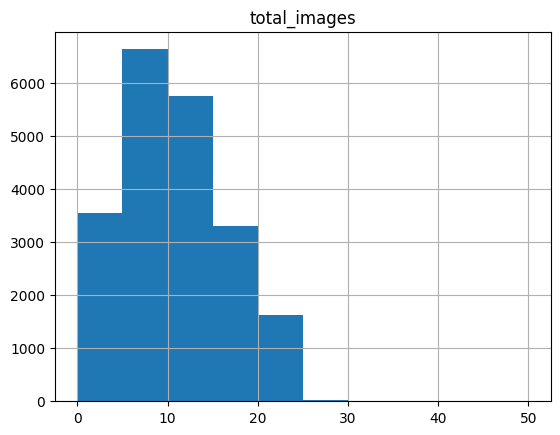

In [66]:
data.hist('total_images');

Данные распределены логично.

**Перейдём к `last_price`**

In [67]:
data['last_price'].describe()

count    2.090400e+04
mean     6.503234e+06
std      9.603780e+06
min      1.219000e+04
25%      3.500000e+06
50%      4.700000e+06
75%      6.800000e+06
max      4.200000e+08
Name: last_price, dtype: float64

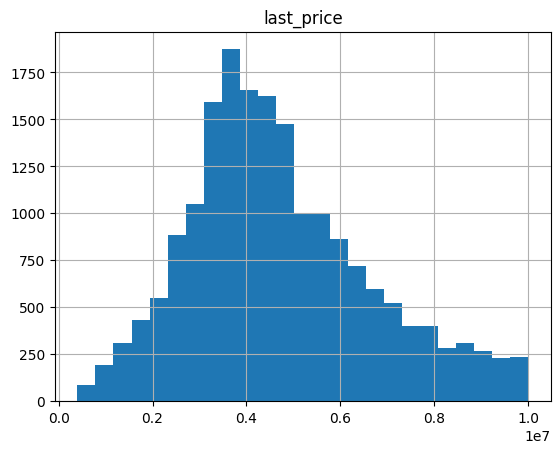

In [68]:
data.hist('last_price', bins=25, range=(400000, 10000000));

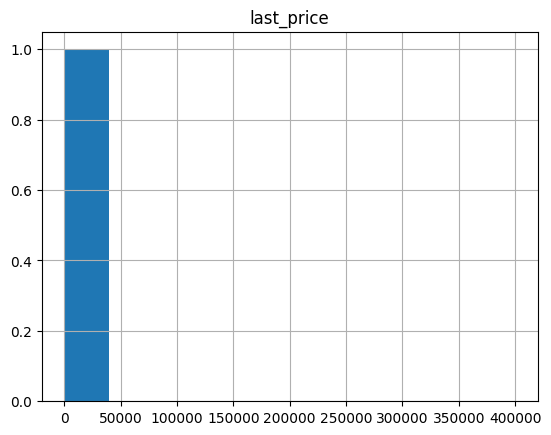

In [69]:
data.hist('last_price', bins=10, range=(0, 400000));

Посмотрили две гистограммы. Одна для диапазона с логичными показаниями для этого столбца, другая чтобы посмотреть сколько аномально низких значений. Высокие значения не рассматривали, так как они не являются аномалиями, а просто выбросами. Максимальное значение 420,000,000р что является логичной ценой для некоторых квартир.

Видим одно аномально низкое значение, удалим его

In [70]:
data = data.query('last_price > 400000').reset_index(drop=True)

**Теперь перейдём к `total_area`**

In [71]:
data['total_area'].describe()

count    20903.000000
mean        60.277185
std         34.501114
min         14.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

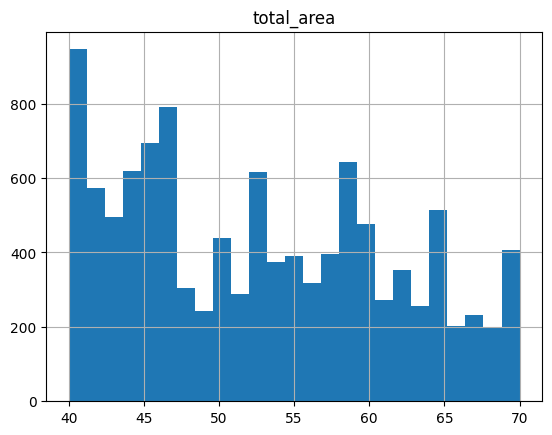

In [72]:
data.hist('total_area', bins=25, range=(40, 70));

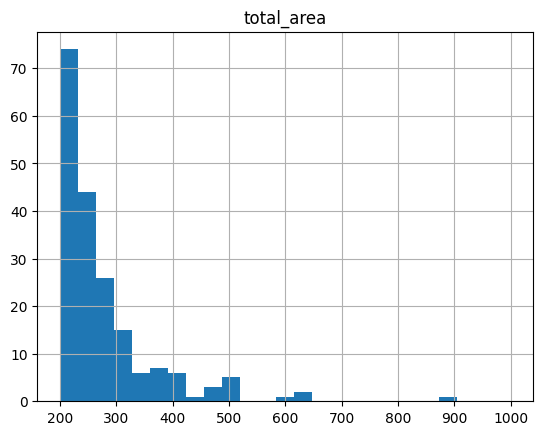

In [73]:
data.hist('total_area', bins=25, range=(200, 1000));

В колонке с общей площадью нет аномалий. Максимальное значение 900 в данном случае не является аномалей, как и другие большие значения, это просто выбросы.

**Рассмотрим количество комнат (`rooms`).**

In [74]:
data['rooms'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 19],
      dtype=int64)

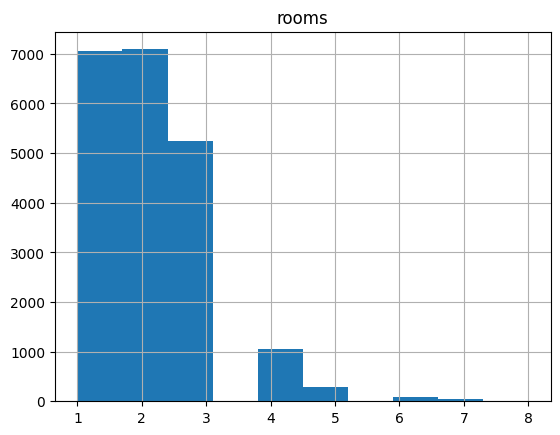

In [75]:
data.hist('rooms', bins=10, range=(1, 8));

Посмотрим внимательнее на большие значения.

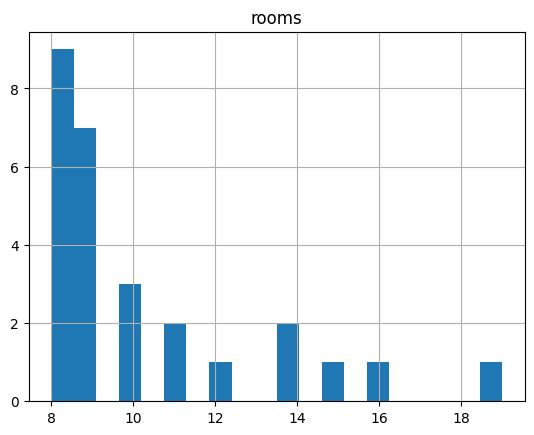

In [76]:
data.hist('rooms', bins=20, range=(8, 19));

Сгрупируем данные по стобцу room используя медиану общей площади для сравнения

In [77]:
data.groupby('rooms')['total_area'].agg(func=['count', 'median'])

,count,median
rooms,,
1,7058,36.0
2,7091,53.0
3,5247,72.0
4,1056,98.5
5,278,146.5
6,95,183.0
7,51,211.0
8,9,235.0
9,7,309.0


Данные до 10 комнат ключительно выглядят логично. Начиная с 11 комнат данных очень мало и выглядят они подозрительно. Удалим строки в которых 11 и больше комнат.

In [78]:
data = data.query('rooms < 11').reset_index(drop=True)

**Посмотрим на `ceiling_height`**

In [79]:
data['ceiling_height'].sort_values().unique()

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.4 ,
         2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,   2.52,
         2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,   2.6 ,
         2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,   2.68,
         2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,   2.76,
         2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,   2.84,
         2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,   2.92,
         2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   3.  ,   3.01,
         3.02,   3.03,   3.04,   3.05,   3.06,   3.07,   3.08,   3.09,
         3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,   3.16,   3.17,
         3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,   3.25,   3.26,
         3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,   3.33,   3.34,
         3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,   3.42,   3.44,
         3.45,   3.46,   3.47,   3.48,   3.49,   3.5 ,   3.51,   3.52,
      

Всё что больше 10м скорей всего неправильно записаны и подразумеваются 1.0м и тд. А вот на минимальные надо посмотреть.

Выведем на гистограмме значения от 1 до 1.9

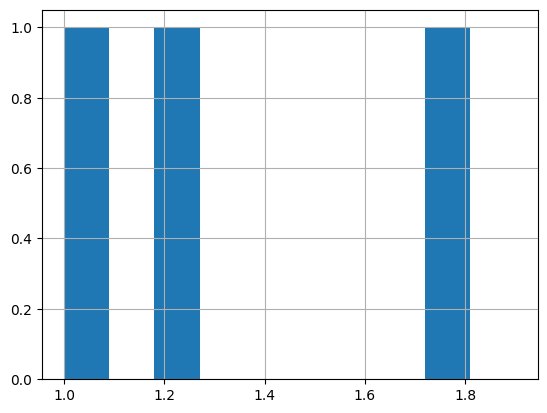

In [80]:
data['ceiling_height'].hist(range=(1, 1.9));

Видим что меньше двух метров всего 3 значения. Можем их удалить

In [81]:
data = data.query('ceiling_height >= 2').reset_index(drop=True)

Теперь займемся значениями больше 10

In [82]:
data.query('ceiling_height > 10').sort_values(by='ceiling_height')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
13309,19,5600000,56,2018-05-11,2,14.0,14,32,5,False,False,False,9,2,санкт-петербург,14814.0,13610.0,0,NaN,0,NaN,315.0
15458,15,6700000,92,2019-02-19,3,20.0,17,53,14,False,False,False,12,5,санкт-петербург,16295.0,15092.0,1,967.0,0,NaN,NaN
18089,12,5950000,60,2018-02-19,2,22.6,14,35,11,False,False,False,13,1,санкт-петербург,27028.0,12570.0,0,NaN,0,NaN,40.0
4472,0,3850000,30,2018-10-03,1,24.0,5,19,1,True,False,False,5,0,санкт-петербург,29686.0,8389.0,3,397.0,1,578.0,7.0
9972,0,1950000,37,2019-03-20,1,25.0,5,17,4,False,False,False,9,2,луга,NaN,NaN,0,NaN,0,NaN,18.0
4101,0,4300000,45,2018-02-01,2,25.0,9,30,2,False,False,False,7,1,санкт-петербург,12016.0,13256.0,1,658.0,1,331.0,181.0
5508,6,3300000,44,2019-03-25,2,25.0,5,31,5,False,False,False,5,0,кронштадт,68923.0,50649.0,1,417.0,2,73.0,NaN
8308,5,3950000,42,2017-03-26,3,25.0,5,30,2,False,False,False,5,0,санкт-петербург,11647.0,13581.0,0,NaN,0,NaN,NaN
12711,9,1700000,35,2015-12-04,1,25.0,5,20,2,False,False,False,8,1,новый свет,NaN,NaN,0,NaN,0,NaN,206.0
4996,4,4400000,50,2017-08-08,2,26.0,9,21,3,False,False,False,7,2,санкт-петербург,28981.0,10912.0,1,305.0,0,NaN,267.0


Строки с высотой потолка 100 и 14 явные аномалии, удалим их.

In [83]:
data = data[~data["ceiling_height"].isin([14, 100])].reset_index(drop=True)

Остальные значения неправильно записаны, как целочисленные, а предпологаются вещественные. Например вместо 20.0 должно быть 2.0. Все значения больше 10 разделим на 10.

In [84]:
data.loc[(data['ceiling_height'] > 10), 'ceiling_height'] = data["ceiling_height"] / 10

Проверим какие значения остались в стобце.

In [85]:
data['ceiling_height'].sort_values().unique()

array([2.  , 2.2 , 2.25, 2.26, 2.3 , 2.4 , 2.45, 2.46, 2.47, 2.48, 2.49,
       2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57, 2.58, 2.59, 2.6 ,
       2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71,
       2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82,
       2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 , 2.91, 2.92, 2.93,
       2.94, 2.95, 2.96, 2.97, 2.98, 3.  , 3.01, 3.02, 3.03, 3.04, 3.05,
       3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15, 3.16,
       3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28,
       3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35, 3.36, 3.37, 3.38, 3.39,
       3.4 , 3.42, 3.44, 3.45, 3.46, 3.47, 3.48, 3.49, 3.5 , 3.51, 3.52,
       3.53, 3.54, 3.55, 3.56, 3.57, 3.58, 3.59, 3.6 , 3.62, 3.63, 3.65,
       3.66, 3.67, 3.68, 3.7 , 3.75, 3.76, 3.78, 3.8 , 3.82, 3.83, 3.84,
       3.85, 3.86, 3.87, 3.88, 3.9 , 3.93, 3.95, 3.98, 4.  , 4.06, 4.1 ,
       4.15, 4.19, 4.2 , 4.25, 4.3 , 4.37, 4.4 , 4.

**Посмотрим на `floors_total`**

In [86]:
data['floors_total'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 35, 36, 52, 60],
      dtype=int64)

Все строки в которых больше 35 этажей аномалии в этих данных. Удалим их.

In [87]:
data = data.query('floors_total < 35').reset_index(drop=True)

**Посмотрим на `living_area`**

In [88]:
data['living_area'].describe()

count    20863.000000
mean        34.316397
std         21.478246
min          2.000000
25%         18.000000
50%         30.000000
75%         42.000000
max        347.000000
Name: living_area, dtype: float64

Видим минимальное значение 2м, посмотрим сколько таких аномально низких значений. Будем считать что жилая прощадь менее 10м - аномалии.

In [89]:
data.query('living_area < 10').sort_values(by='living_area')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
12288,20,6350000,52,2018-02-06,2,3.00,6,2,2,False,False,False,9,0,санкт-петербург,32453.0,6521.0,0,NaN,1,1012.0,91.0
20759,14,64990000,139,2015-11-24,3,3.00,8,3,8,False,False,False,16,1,санкт-петербург,33255.0,5975.0,1,630.0,3,100.0,280.0
2861,7,4440000,41,2017-07-02,1,2.65,17,3,17,False,False,False,11,0,санкт-петербург,19272.0,13073.0,0,NaN,0,NaN,216.0
19334,15,6100000,77,2019-02-28,4,2.50,9,5,1,False,False,False,9,0,санкт-петербург,29338.0,11270.0,1,584.0,0,NaN,33.0
16962,19,4050000,33,2018-10-15,1,2.50,22,6,21,False,False,False,18,0,санкт-петербург,9258.0,10592.0,1,458.0,0,NaN,44.0
14500,13,3799000,31,2018-04-12,1,2.60,5,6,1,False,False,False,17,0,санкт-петербург,32177.0,4826.0,1,430.0,0,NaN,168.0
2050,10,4200000,62,2017-06-15,2,2.60,9,8,6,False,False,False,41,2,посёлок шушары,23662.0,29448.0,0,NaN,0,NaN,111.0
20428,12,4800000,37,2016-02-24,1,2.65,14,8,11,False,False,False,22,0,санкт-петербург,27838.0,12387.0,2,358.0,1,950.0,139.0
15221,20,5300000,33,2017-04-14,1,2.70,22,8,16,False,False,False,16,1,санкт-петербург,33803.0,13671.0,0,NaN,0,NaN,216.0
18488,7,8900000,50,2018-10-22,2,2.50,7,8,3,False,False,False,31,0,санкт-петербург,12771.0,8301.0,1,173.0,3,126.0,NaN


В данных нашли 22 строки с аномально низкой жилой площадью. Удалим их.

In [90]:
data = data.query('living_area > 10').reset_index(drop=True)

Квартиры с большой жилой площадью являются выбросами, а не аномалиями.

**Посмотрим на `floor`**

In [91]:
data['floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 32], dtype=int64)

В этой колонке аномалий нет.

**Посмотрим на `kitchen_area`**

In [92]:
data['kitchen_area'].describe()

count    20802.000000
mean        10.226805
std          5.761605
min          1.000000
25%          7.000000
50%          9.000000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

In [93]:
data['kitchen_area'].sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  53,
        54,  55,  56,  58,  60,  62,  63,  64,  65,  66,  70,  72,  75,
        77,  87,  93, 100, 107], dtype=int64)

Кухни меньше 5м² являются аномалиями, удалим их.

In [94]:
data = data.query('kitchen_area >= 5').reset_index(drop=True)

Кухни больше 50м² с большой вероятностью являются аномалиями, посмотрим сколько их.

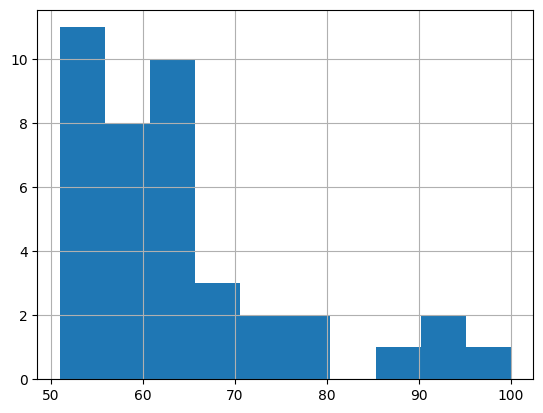

In [95]:
data['kitchen_area'].hist(bins=10, range=(51, 100));

In [96]:
data.query('kitchen_area > 50').sort_values(by='kitchen_area', ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
17676,2,85000000,249,2018-02-01,3,2.65,10,72,9,False,False,False,107,4,санкт-петербург,31532.0,4624.0,1,2218.0,2,99.0,26.0
2187,9,12500000,255,2017-04-21,3,2.65,2,153,2,False,False,False,100,0,санкт-петербург,29544.0,6916.0,0,NaN,3,198.0,102.0
14710,9,65850000,146,2017-07-14,2,2.65,9,40,3,False,False,False,93,0,санкт-петербург,25525.0,5845.0,2,116.0,0,NaN,77.0
14224,5,82400000,181,2017-05-24,3,3.90,9,58,4,False,False,False,93,0,санкт-петербург,25525.0,5845.0,2,116.0,0,NaN,501.0
9507,1,56844500,177,2015-01-15,3,2.65,6,87,5,True,False,False,87,0,санкт-петербург,21860.0,318.0,2,160.0,3,569.0,NaN
438,18,95000000,216,2017-12-05,4,3.00,5,86,4,False,False,False,77,0,санкт-петербург,21740.0,436.0,2,138.0,3,620.0,14.0
3845,20,57000000,174,2015-11-09,3,3.20,10,95,6,False,False,False,77,0,санкт-петербург,31706.0,4166.0,1,193.0,3,199.0,1039.0
12826,17,47000000,150,2017-02-28,4,3.70,6,58,5,False,False,False,75,1,санкт-петербург,16085.0,7616.0,0,NaN,0,NaN,507.0
14579,15,122000000,145,2017-04-25,3,3.30,6,36,2,False,False,False,72,0,санкт-петербург,33931.0,7023.0,2,478.0,3,250.0,335.0
5413,19,24300000,230,2016-06-03,4,2.65,3,90,2,False,False,False,70,0,санкт-петербург,39422.0,15354.0,0,NaN,1,345.0,397.0


Нашли 41 строку с кухнями больше 50м², удалим их.

In [97]:
data = data.query('kitchen_area < 50').reset_index(drop=True)

**Посмотрим на `balcony`**

In [98]:
data['balcony'].sort_values().unique()

array([0, 1, 2, 3, 4, 5], dtype=int64)

Аномалий в данной колонке нет.

**Посмотрим на `airports_nearest`**

In [99]:
data['airports_nearest'].describe()

count    16032.000000
mean     28808.859375
std      12646.534180
min       6450.000000
25%      18497.500000
50%      26766.000000
75%      37275.500000
max      84869.000000
Name: airports_nearest, dtype: float64

На этапе обработки пропусков мы уже удалили аномалии в этой колонке

**Посмотрим на `cityCenters_nearest`**

In [100]:
data['cityCenters_nearest'].describe()

count    16053.000000
mean     14240.053711
std       8632.330078
min        181.000000
25%       9399.000000
50%      13107.000000
75%      16228.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

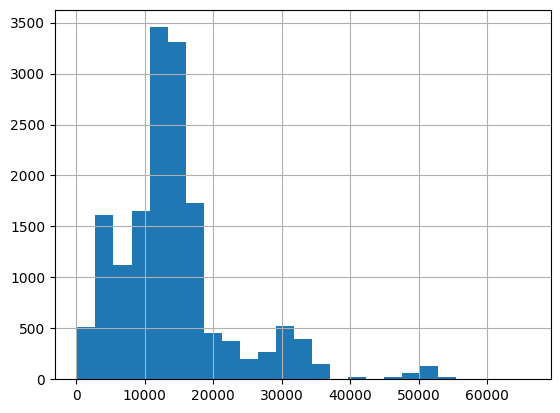

In [101]:
data['cityCenters_nearest'].hist(bins=25);

В этой колонке нет аномалий.

**Посмотрим на `parks_around3000`**

In [102]:
data['parks_around3000'].sort_values().unique()

array([0, 1, 2, 3], dtype=int64)

В этой колонке нет аномалий.

**Посмотрим на `parks_nearest`**

In [103]:
data['parks_nearest'].describe()

count    7153.000000
mean      488.114075
std       337.685181
min         1.000000
25%       287.000000
50%       453.000000
75%       611.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Видим что есть аномально низкие значения. Проверим сколько их.

In [104]:
data.query('parks_nearest < 10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
2214,8,4690000,60,2016-03-05,2,2.50,5,28,2,False,False,False,7,0,кронштадт,69775.0,51500.0,3,9.0,3,345.0,146.0
8177,12,3000000,28,2017-07-25,1,2.50,9,17,1,False,False,False,5,0,санкт-петербург,12051.0,11665.0,1,7.0,1,780.0,440.0
10439,7,4500000,44,2017-11-24,2,2.60,9,30,7,False,False,False,7,0,санкт-петербург,11806.0,12292.0,1,3.0,1,508.0,82.0
12779,8,3770000,45,2019-03-20,2,2.65,9,28,2,False,False,False,6,0,санкт-петербург,43932.0,16436.0,1,1.0,0,NaN,42.0


Приняли растояние меньше чем 10м за аномалии, нашли 4 строки, удалим их.

In [105]:
data.drop(data.loc[data['parks_nearest'] < 10].index, inplace=True)
data = data.reset_index(drop=True)

**Посмотрим на `ponds_around3000`**

In [106]:
data['ponds_around3000'].sort_values().unique()

array([0, 1, 2, 3], dtype=int64)

В этой колонке нет аномалий.

**Посмотрим на `ponds_nearest`**

In [107]:
data['ponds_nearest'].describe()

count    7923.000000
mean      521.472412
std       276.375000
min        13.000000
25%       298.000000
50%       505.000000
75%       733.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Будем считать что значения меньше 20м аномалии, найдём сколько их.

In [108]:
data.query('ponds_nearest < 20').sort_values(by='ponds_nearest')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1357,1,12300000,90,2018-03-03,3,2.65,8,55,3,False,False,False,14,0,санкт-петербург,18689.0,17691.0,1,1145.0,2,13.0,347.0
15350,14,12900000,86,2018-12-08,3,2.65,8,45,7,False,False,False,22,0,санкт-петербург,18689.0,17691.0,1,1145.0,2,13.0,NaN
1519,8,8300000,70,2016-01-29,2,3.20,8,42,7,False,False,False,12,2,санкт-петербург,18140.0,17143.0,1,1514.0,2,16.0,200.0
7678,18,15500000,105,2019-03-15,3,2.65,10,63,3,False,False,False,17,0,санкт-петербург,18140.0,17143.0,1,1514.0,2,16.0,NaN
9041,8,16399282,205,2017-06-29,4,2.65,8,84,1,False,False,False,11,0,санкт-петербург,18140.0,17143.0,1,1514.0,2,16.0,NaN
16434,9,8600000,68,2018-08-19,2,3.06,17,33,13,False,False,False,13,2,санкт-петербург,18140.0,17143.0,1,1514.0,2,16.0,31.0
17807,1,12600000,129,2017-05-11,5,2.65,8,81,3,False,False,False,14,1,санкт-петербург,18140.0,17143.0,1,1514.0,2,16.0,90.0
19246,11,10300000,84,2017-12-08,3,2.65,8,51,5,False,False,False,12,0,санкт-петербург,18140.0,17143.0,1,1514.0,2,16.0,78.0
20333,12,11900000,85,2017-04-10,3,2.65,8,51,7,False,False,False,13,0,санкт-петербург,18140.0,17143.0,1,1514.0,2,16.0,475.0
2244,7,3900000,44,2017-05-23,1,2.65,16,20,5,False,False,False,10,2,санкт-петербург,18649.0,17652.0,1,1304.0,2,19.0,45.0


Нашли 13 строк, удалим их.

In [109]:
data.drop(data.loc[data['ponds_nearest'] < 20].index, inplace=True)
data = data.reset_index(drop=True)

**Посмотрим на `days_exposition`**

In [110]:
data['days_exposition'].describe()

count    17786.000000
mean       185.361572
std        221.907303
min          1.000000
25%         45.000000
50%        102.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

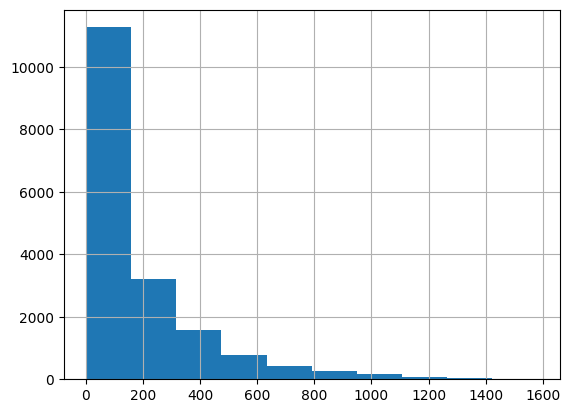

In [111]:
data['days_exposition'].hist();

Данные выглядят логично, аномалий нет.

Посмотрим общую информацию о датафрейме после обработки аномалий, а так же на процент удалённых данных.

In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20628 entries, 0 to 20627
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20628 non-null  int64         
 1   last_price            20628 non-null  int64         
 2   total_area            20628 non-null  int64         
 3   first_day_exposition  20628 non-null  datetime64[ns]
 4   rooms                 20628 non-null  int64         
 5   ceiling_height        20628 non-null  float32       
 6   floors_total          20628 non-null  int64         
 7   living_area           20628 non-null  int64         
 8   floor                 20628 non-null  int64         
 9   is_apartment          20628 non-null  bool          
 10  studio                20628 non-null  bool          
 11  open_plan             20628 non-null  bool          
 12  kitchen_area          20628 non-null  int64         
 13  balcony         

In [113]:
data.shape[0] / original_data.shape[0]

0.8704164732689142

**Выводы по обработке аномалий**

Проверили каждую колонку в которой потенциально могли находится аномалии.
- Удалили одно аномально низкое значение в колонке `last_price`.
- Удалили все строки в которых значение в колонке `rooms` было больше 10. Таких данных было мало и выглядели они не логично.
- В колонке `ceiling_height` хранящую высоту потолков нашли ошибочно заполненные данные, а так же несколько аномалий которые удалили. Ошибочно заполненые данные исправили.
- Удалили очень высокие значения в колонке `floors_total`.
- В данных по жилой площади (`living_area`)и площади кухни (`kitchen_area`) удалили аномалии.
- В колонках `parks_nearest` и `ponds_nearest` удалили аномалии.

По итогам обработки аномалий удалили около 250 строк.

По итогам предобработки у нас осталось 87% от изначальных данных.

С предобработкой закончили. Можем приступать к следующему этапу.

<a id='new_columns'></a>
## Посчитаем и добавим в таблицу новые столбцы

**Рассчитаем цену одного квадратного метра и добавим в таблицу**

In [114]:
data['price_per_meter'] = (data['last_price'] / data['total_area']).astype('int64')

**Добавим в таблицу день публикации объявления**

In [115]:
data['publish_day'] = pd.DatetimeIndex(data['first_day_exposition']).weekday

**Добавим в таблицу месяц публикации объявления**

In [116]:
data['publish_month'] = pd.DatetimeIndex(data['first_day_exposition']).month

**Добавим в таблицу год публикации объявления**

In [117]:
data['publish_year'] = pd.DatetimeIndex(data['first_day_exposition']).year

**Создадим колонку с категориями по этажам**

Разбиваем на 3 категории - "первый", "последний", "другой"

In [118]:
def categorize_floor(row):
    floor = row['floor']
    floor_total = row['floors_total']
    if floor == 1:
         return 'первый'
    if floor == floor_total:
          return 'последний'
    return 'другой'

In [119]:
data['floor_category'] = data.apply(categorize_floor, axis=1)

**Посчитаем и добавим в таблицу расстояние в км до центра города**

In [120]:
data['centers_nearest_km'] = round((data['cityCenters_nearest'] / 1000), 1)
data['centers_nearest_km'] = data['centers_nearest_km'].apply(np.ceil)

**Посмотрим как первые 5 строк выглядят после добавления новых столбцов.**

In [121]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_meter,publish_day,publish_month,publish_year,floor_category,centers_nearest_km
0,20,13000000,108,2019-03-07,3,2.70,16,51,8,False,False,False,25,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,120370,3,3,2019,другой,16.0
1,7,3350000,40,2018-12-04,1,2.65,11,18,1,False,False,False,11,2,посёлок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,83750,1,12,2018,первый,19.0
2,10,5196000,56,2015-08-20,2,2.65,5,34,4,False,False,False,8,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,92785,3,8,2015,другой,14.0
3,2,10000000,100,2018-06-19,2,3.03,14,32,13,False,False,False,41,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,100000,1,6,2018,другой,9.0
4,10,2890000,30,2018-09-10,1,2.65,12,14,5,False,False,False,9,0,янино-1,NaN,NaN,0,NaN,0,NaN,55.0,96333,0,9,2018,другой,NaN


**Вывод по добалению новых стобцов**

Добавили 6 столбцов которые нам понадобятся для иссоедовательского анализа данных. Растояние до центра в км оставили в типе float, так как мы оставили пропуски в оригинальной колонке.

<a id='eda'></a>
## Проведём исследовательский анализ данных

<a id='ed'></a>
### Изучение имеющихся данных

**Начнём с общей площади**

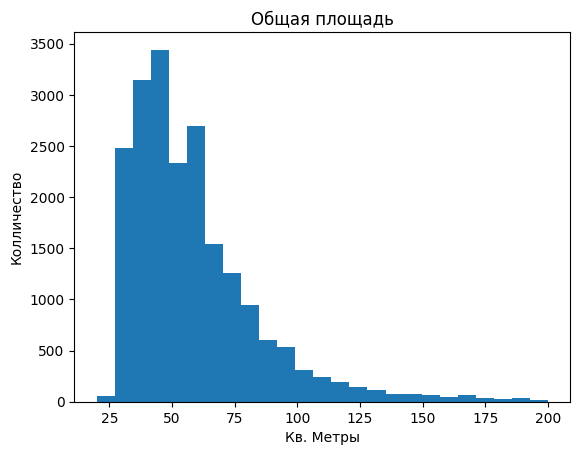

In [122]:
fig, ax = plt.subplots()
ax.hist(data['total_area'], bins=25, range=(20, 200));
ax.set_title('Общая площадь')
ax.set_xlabel('Кв. Метры')
ax.set_ylabel('Колличество')
plt.show()

Основная часть приходится на квартиры с общей площадью в районе 30-70 квадратных метра.

**Жилая площадь**

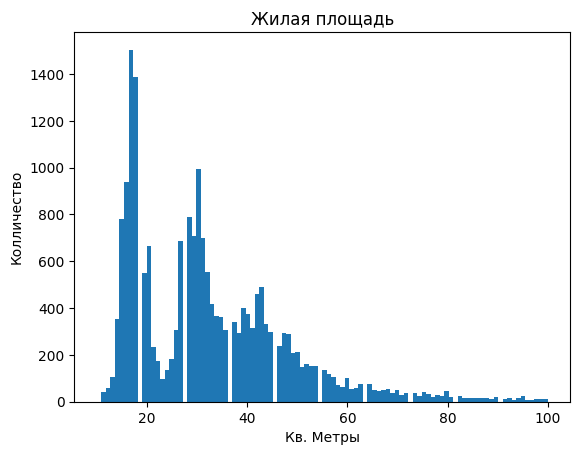

In [123]:
fig, ax = plt.subplots()
ax.hist(data['living_area'], bins=100, range=(10, 100));
ax.set_title('Жилая площадь')
ax.set_xlabel('Кв. Метры')
ax.set_ylabel('Колличество')
plt.show()

Основная часть приходится на квартиры с жилой площадью в районе 18 и 30 квадратных метра. Скорей всего однокомнатные и двухкомнатные соответсвенно. Потом видим маленький пик в районе 42 квадратных метра, это могут быть трехкомнатные квартиры. После этого идёт длинных хвост

**Площадь кухни**

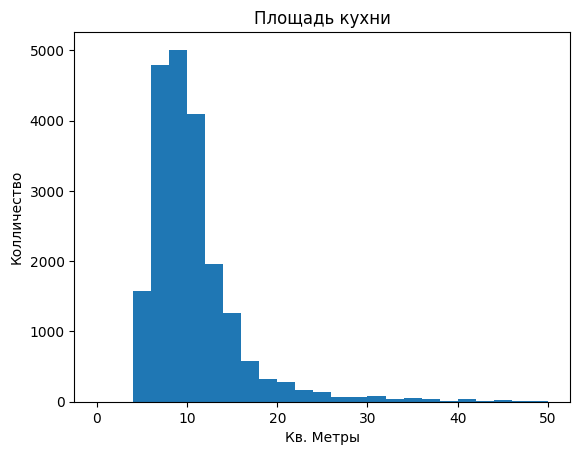

In [124]:
fig, ax = plt.subplots()
ax.hist(data['kitchen_area'], bins=25, range=(0, 50));
ax.set_title('Площадь кухни')
ax.set_xlabel('Кв. Метры')
ax.set_ylabel('Колличество')
plt.show()

Основная часть приходится на квартиры с площадью кухни в районе 6-12 квадратных метра.

**Цена объекта**

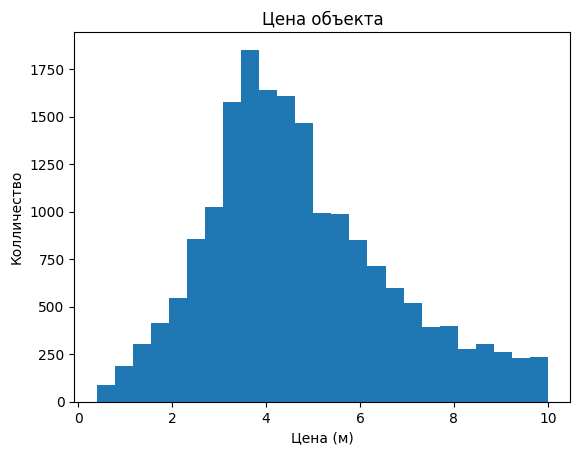

In [125]:
fig, ax = plt.subplots()
ax.hist((data['last_price'] / 1000000), bins=25, range=(0.4, 10));
ax.set_title('Цена объекта')
ax.set_xlabel('Цена (м)')
ax.set_ylabel('Колличество')
plt.show()

Основная часть приходится на квартиры с ценой около 3,000,000р - 5,000,000р.

**Количество комнат**

In [126]:
data.groupby('rooms')['rooms'].count()

rooms
1     6944
2     7012
3     5202
4     1044
5      268
6       92
7       48
8        9
9        6
10       3
Name: rooms, dtype: int64

Самые распространённые квартиры - одно- и двухкомнатные. Доля трёхкомнатных тоже большая. Потом идёт резкий спад.

**Высота потолков**

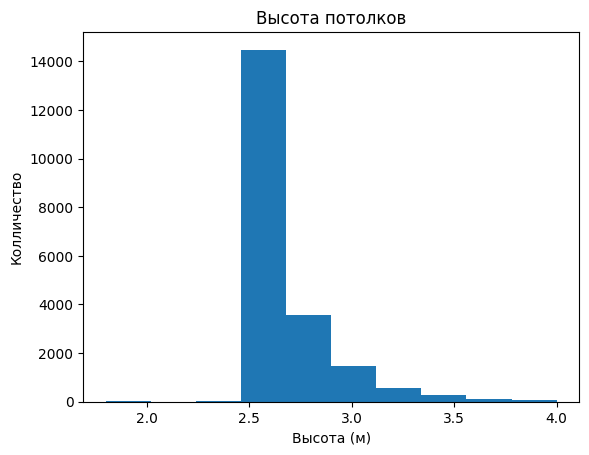

In [127]:
fig, ax = plt.subplots()
ax.hist(data['ceiling_height'], range=(1.8, 4));
ax.set_title('Высота потолков')
ax.set_xlabel('Высота (м)')
ax.set_ylabel('Колличество')
plt.show()

Типичная высота потолков в диапазоне 2,5м - 2,7м.

**Этаж квартиры**

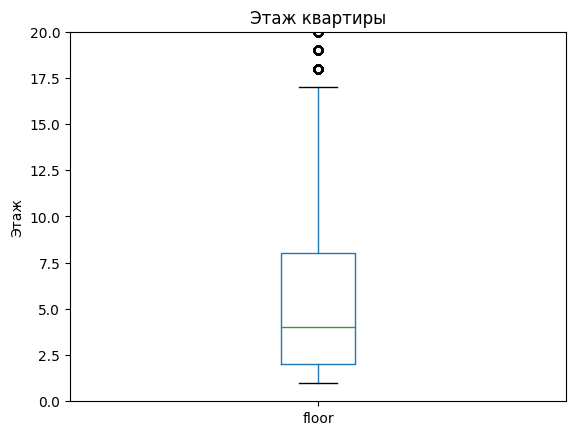

In [128]:
fig, ax = plt.subplots()
data['floor'].plot(kind='box', ylim=(0, 20));
ax.set_title('Этаж квартиры')
ax.set_ylabel('Этаж')
plt.show()

Основная часть приходтся на диапазон 1-9 этаж.

**Тип этажа квартиры**

In [129]:
data.groupby('floor_category')['floor_category'].count()

floor_category
другой       15168
первый        2519
последний     2941
Name: floor_category, dtype: int64

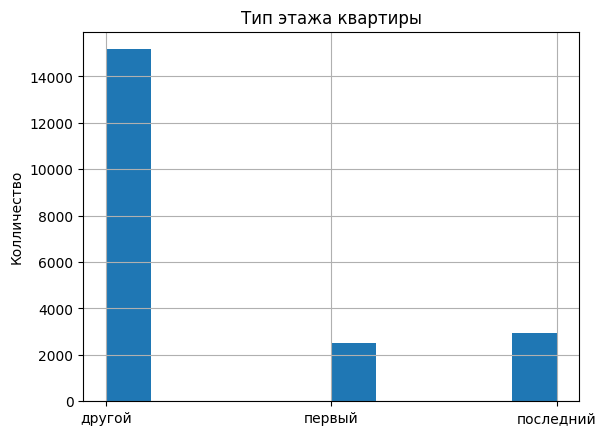

In [130]:
fig, ax = plt.subplots()
data['floor_category'].hist();
ax.set_title('Тип этажа квартиры')
ax.set_ylabel('Колличество')
plt.show()

Большая часть приходтся на этажи отличающиеся от первого или последнего.

**Общее количество этажей в доме**

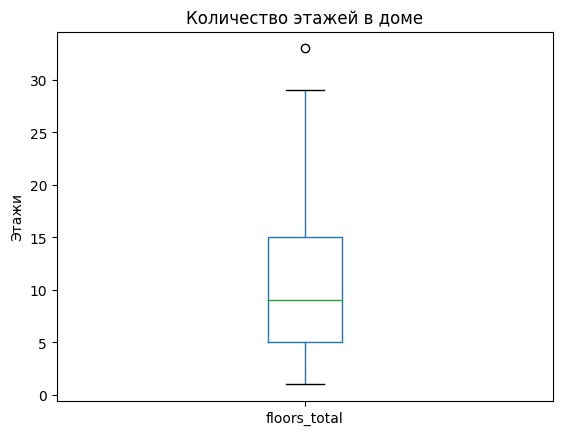

In [131]:
fig, ax = plt.subplots()
data['floors_total'].plot(kind='box');
ax.set_title('Количество этажей в доме')
ax.set_ylabel('Этажи')
plt.show()

Больше всего значений в диапазоне 5-15 этажных домов.

**Расстояние до центра города в метрах**

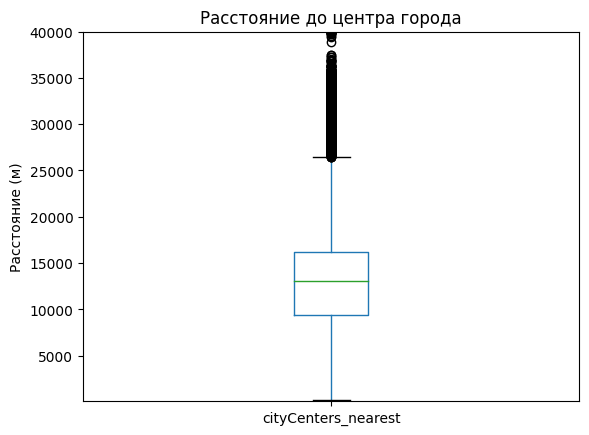

In [132]:
fig, ax = plt.subplots()
data['cityCenters_nearest'].plot(kind='box', ylim=(100, 40000));
ax.set_title('Расстояние до центра города')
ax.set_ylabel('Расстояние (м)')
plt.show()

Большинство квартир находятся на растоянии 10000-16000м от центра.

**Расстояние до ближайшего аэропорта**

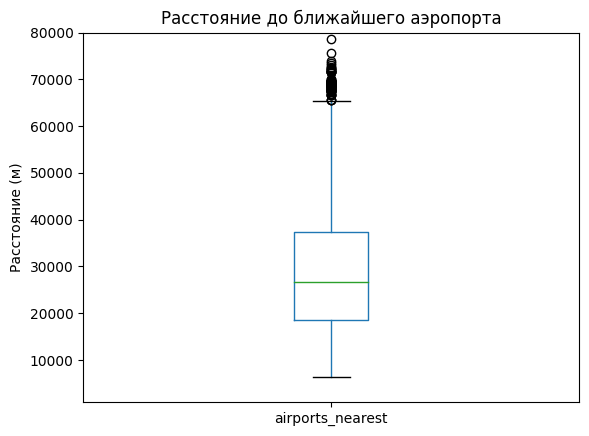

In [133]:
fig, ax = plt.subplots()
data['airports_nearest'].plot(kind='box', ylim=(1000, 80000));
ax.set_title('Расстояние до ближайшего аэропорта')
ax.set_ylabel('Расстояние (м)')
plt.show()

Для большинтва квартир растояние до аэропорта находтся в диапазоне 20-38км.

**Расстояние до ближайшего парка**

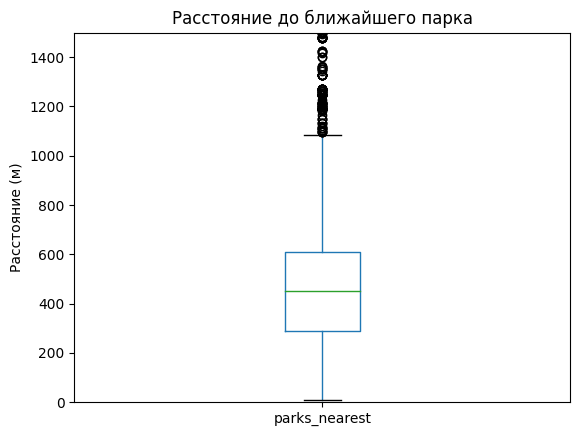

In [134]:
fig, ax = plt.subplots()
data['parks_nearest'].plot(kind='box', ylim=(0, 1500));
ax.set_title('Расстояние до ближайшего парка')
ax.set_ylabel('Расстояние (м)')
plt.show()

Типичное расстояние до парка находится в диапазоне 300-600м.

**День и месяц публикации объявления**

In [135]:
data.groupby('publish_day')['publish_day'].count()

publish_day
0    3196
1    3662
2    3459
3    3759
4    3491
5    1637
6    1424
Name: publish_day, dtype: int64

Наиболее частпространённые дни публикации объявления вторник и среда, в остальные будние дни значения тоже высокие. В выходные падают больше чем в два раза.

In [136]:
data.groupby('publish_month')['publish_month'].count()

publish_month
1     1236
2     2276
3     2227
4     2100
5     1115
6     1543
7     1454
8     1518
9     1800
10    1904
11    2143
12    1312
Name: publish_month, dtype: int64

Есть спад публикуемых объявлений в декабре и январе, а так же в мае. В остальные месяцы количество публикуемых объявлений примерно одинаковое.

Сделаем тепловую карту на которой отобразим по оси x - дни недели, а по оси y - месяцы.

publish_day,0,1,2,3,4,5,6
publish_month,,,,,,,
1,240,201,223,166,199,114,93
2,308,391,311,666,299,152,149
3,360,421,346,364,370,203,163
4,399,365,285,371,373,158,149
5,153,188,235,220,198,64,57
6,180,248,248,331,306,135,95
7,277,291,233,216,183,147,107
8,237,284,301,254,237,112,93
9,237,324,363,279,289,159,149


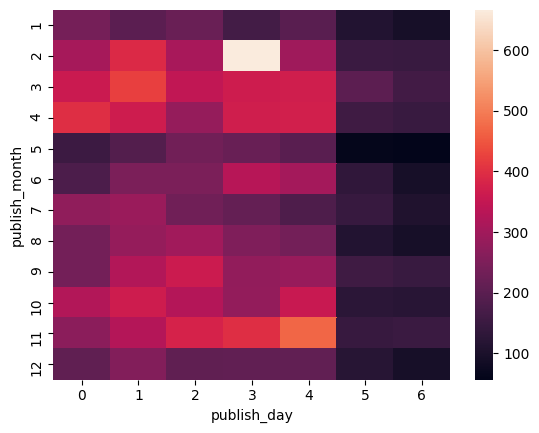

In [137]:
sns.heatmap((data.pivot_table(index='publish_month', columns='publish_day', values='publish_year', aggfunc='count')))
display(data.pivot_table(index='publish_month', columns='publish_day', values='publish_year', aggfunc='count'))

Видим одно выбивающееся значение согласно которому больше всего публикаций объявления пришлись на четверга в марте. Остальные данные выглядят более менее однородно и логично, более яркие цвета видим в будние дни(больше объявлений) и темные на выходных(меньше объявлений).

**Вывод по имеющимся данным**

Посмотрели на данные и нашли наиболее распространённые значения. Можем приступать к исследованию.

<a id='sale_speed'></a>
### Изучение скорости продаж квартир

Посмотрим гистограмму по количеству дней от публикации до снятия объявления

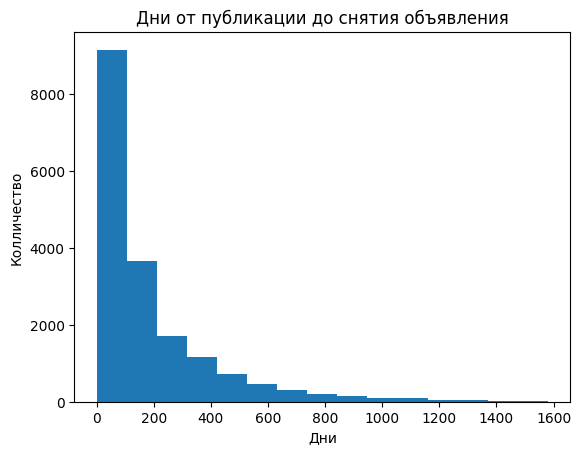

In [138]:
fig, ax = plt.subplots()
ax.hist(data['days_exposition'], bins=15);
ax.set_title('Дни от публикации до снятия объявления')
ax.set_xlabel('Дни')
ax.set_ylabel('Колличество')
plt.show()

Видим что большинство объявлений было снято до 200 дней. После это отметки идёт длинный хвост.

Методом describe узнаем медиану и среднее значение и построим диаграмму размаха.

In [139]:
data['days_exposition'].describe()

count    17786.000000
mean       185.361572
std        221.907303
min          1.000000
25%         45.000000
50%        102.000000
75%        239.000000
max       1580.000000
Name: days_exposition, dtype: float64

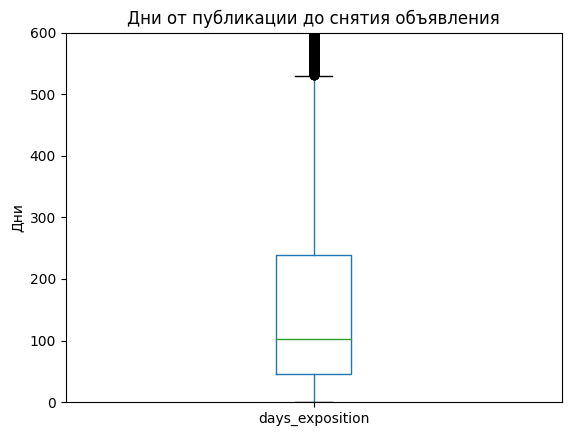

In [140]:
fig, ax = plt.subplots()
data['days_exposition'].plot(kind='box', ylim=(0, 600));
ax.set_title('Дни от публикации до снятия объявления')
ax.set_ylabel('Дни')
plt.show()

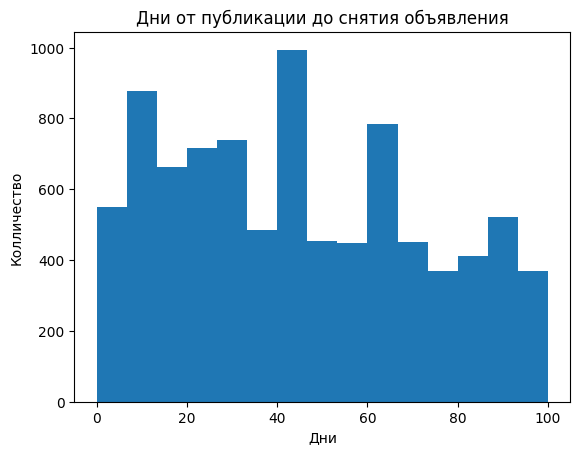

In [141]:
fig, ax = plt.subplots()
ax.hist(data['days_exposition'], bins=15, range=(0, 100));
ax.set_title('Дни от публикации до снятия объявления')
ax.set_xlabel('Дни')
ax.set_ylabel('Колличество')
plt.show()

**Вывод по скорости продаж квартир**

Медина - 102 дня, среднее - 185. Мы наблюдаем повышенное среднее из-за длинного хвоста значений, то малое количество объявлений которое не снято в течении долгого времени искажает среднее значение. Продажи более 200 дней можем считать долгими, а более 500 дней - необычно долгими. Быстрыми продажами можем назвать те которые произошли в течении месяца после публикации объявления. Нормальная скорость продажи примерно от 40 дней до полугода.

<a id='price_factors'></a>
### Факторы влияющие на стоимость объекта

**Посмотрим на зависимость цены от общей площади**

Построим диаграмму рассеяния, зададим по оси x - общую площадь, по оси y - цену.

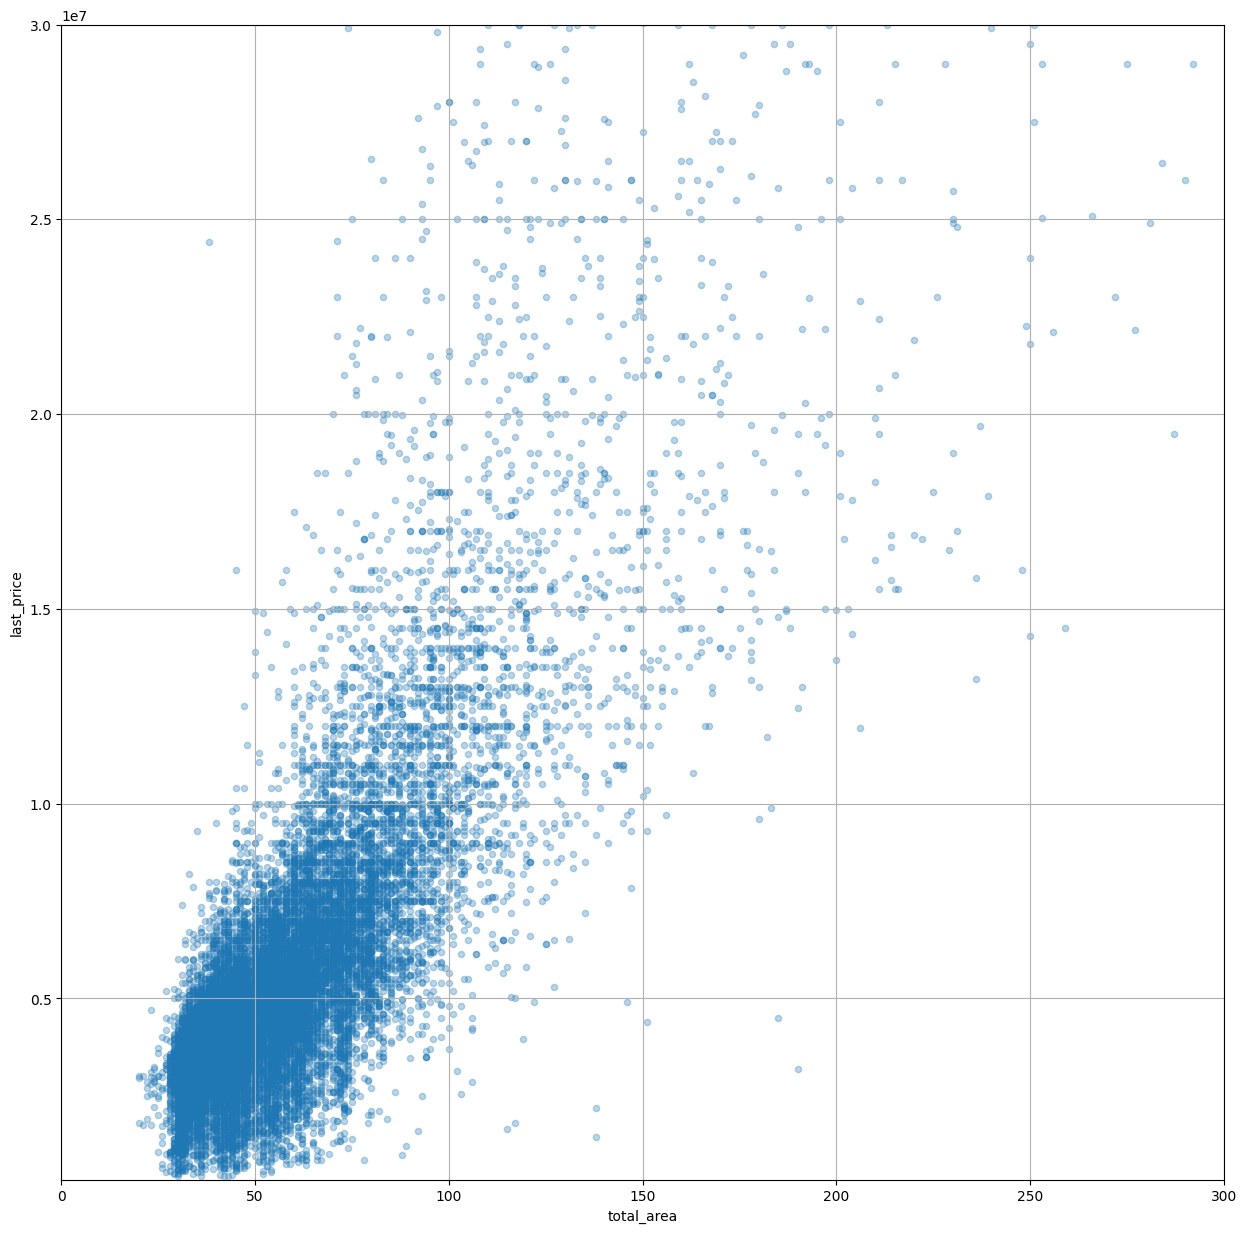

In [142]:
data.plot(x='total_area',
          y='last_price',
          kind='scatter',
          xlim=(0,300),
          ylim=(350000, 30000000),
          grid=True,
          alpha=0.3,
          figsize=(15, 15)
         );

Видим что основная часть значений приходится на диапазоны: площадь 30-70кв.метров, цена 400,000-700,000р. Присутсвует корреляция роста цены и площади.

Посчитаем коэффициент Пирсона.

In [143]:
print(data['total_area'].corr(data['last_price']))

0.6697241900028498


Коэффициент Пирсона 67% подтвержадющий наш вывод о присутсвии корреляцию, но она не сильно выраженная.

**Посмотрим на зависимотсть цены от жилой площади**

Построим диаграмму рассеяния, зададим по оси x - жилую площадь, по оси y - цену.

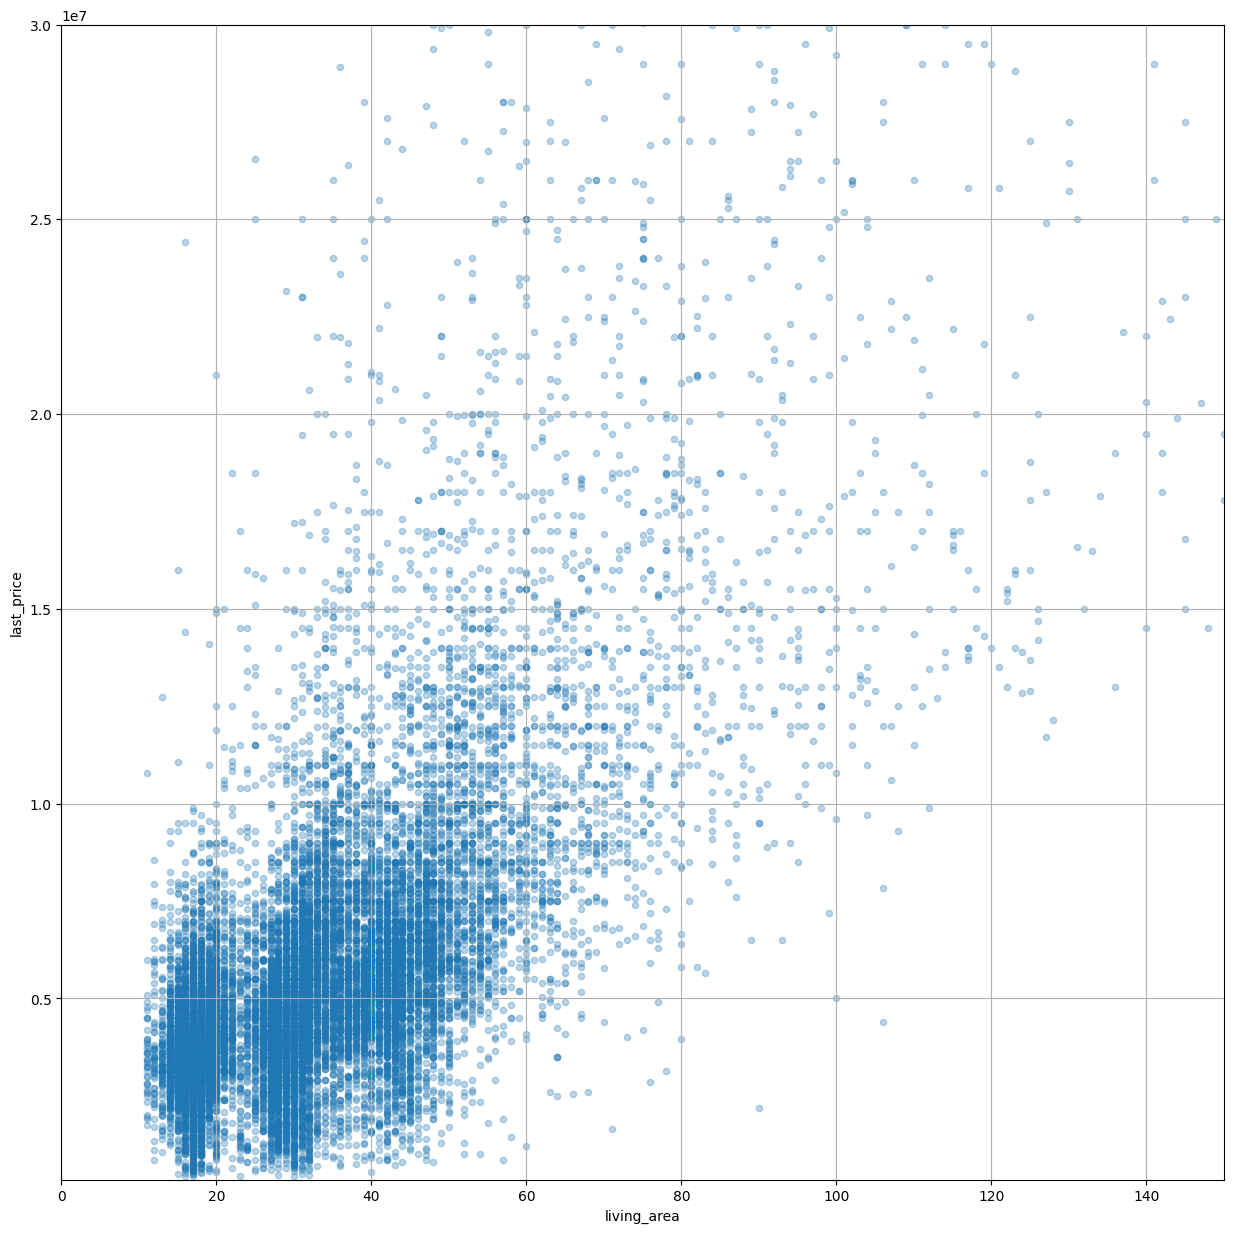

In [144]:
data.plot(x='living_area',
          y='last_price',
          kind='scatter',
          xlim=(0,150),
          ylim=(350000, 30000000),
          grid=True,
          alpha=0.3,
          figsize=(15, 15)
         );

Видим что основная часть значений приходится на диапазоны: жилая площадь 15-50кв.метров, цена 400,000-700,000р. Корреляция роста цены и жилой площади слабая.

Посчитаем коэффициент Пирсона.

In [145]:
print(data['living_area'].corr(data['last_price']))

0.5972204500948983


Коэффициент Пирсона 60%. Корреляция слабее чем с общеё площадью, но присутсвует.

**Посмотрим на зависимотсть цены от площади кухни**

Построим диаграмму рассеяния, зададим по оси x - площадь кухни, по оси y - цену.

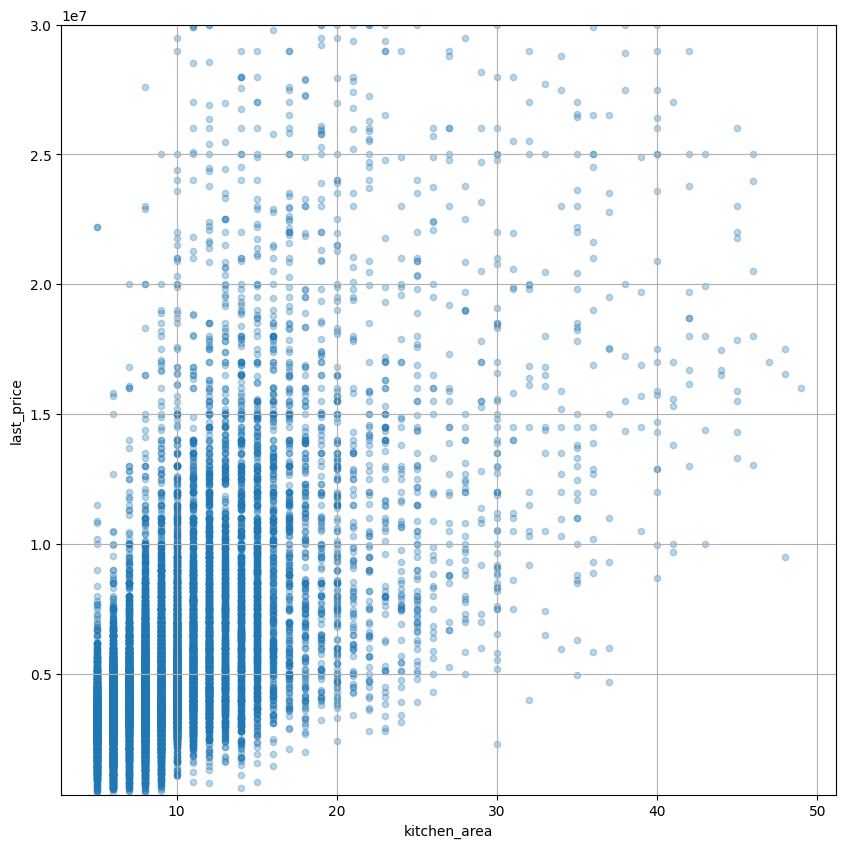

In [146]:
data.plot(x='kitchen_area',
          y='last_price',
          kind='scatter',
          ylim=(350000, 30000000),
          grid=True,
          alpha=0.3,
          figsize=(10, 10)
         );

Видим что основная часть значений приходится на диапазоны: площадь кухни 6-15кв.метров, цена 400,000-700,000р. Корреляция роста цены и площади кухни очень слабая.

Посчитаем коэффициент Пирсона.

In [147]:
print(data['kitchen_area'].corr(data['last_price']))

0.4665179158834506


Коэффициент Пирсона 47%. Корреляция очень слабая.

**Посмотрим на зависимотсть цены от количества комнат**

Построим диаграмму рассеяния, зададим по оси x - количество комнат, по оси y - цену.

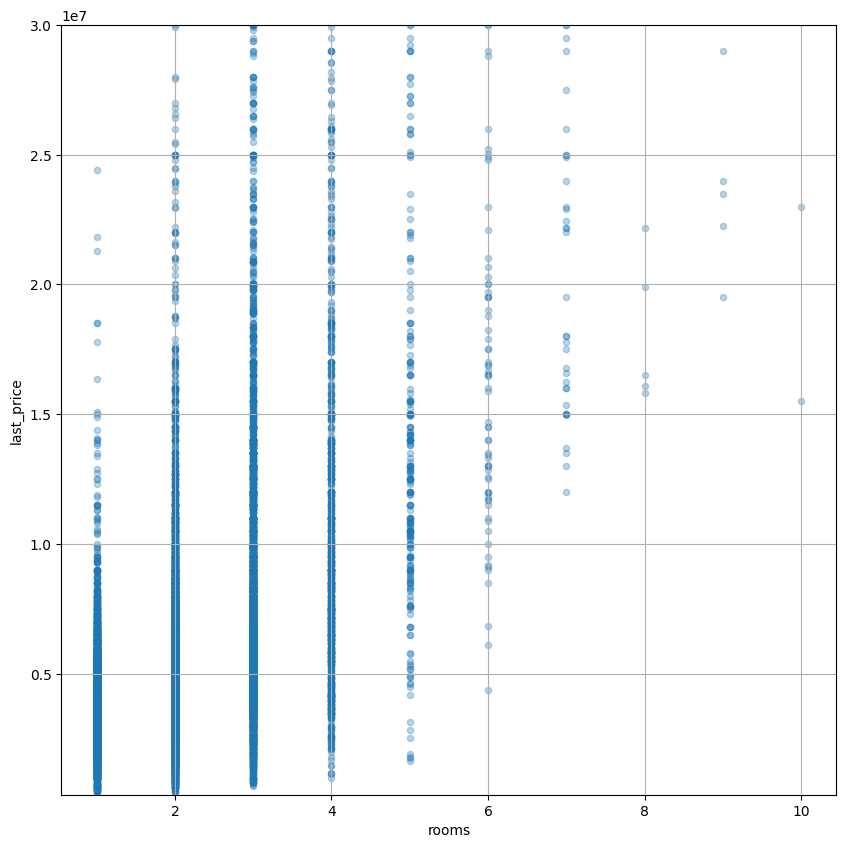

In [148]:
data.plot(x='rooms',
          y='last_price',
          kind='scatter',
          ylim=(350000, 30000000),
          grid=True,
          alpha=0.3,
          figsize=(10, 10)
         );

Видим что основная часть значений приходится на диапазоны: количество комнат 1-3, цена 400,000-700,000р. Корреляция по сути отсутсвует.

Посчитаем коэффициент Пирсона.

In [149]:
print(data['rooms'].corr(data['last_price']))

0.38997100079138297


Коэффициент Пирсона 39%. Корреляция практически отсутвует.

**Посмотрим на зависимотсть цены от количества комнат по категориям**

Построим диаграмму рассеяния, зададим по оси x - категории комнат, по оси y - цену.

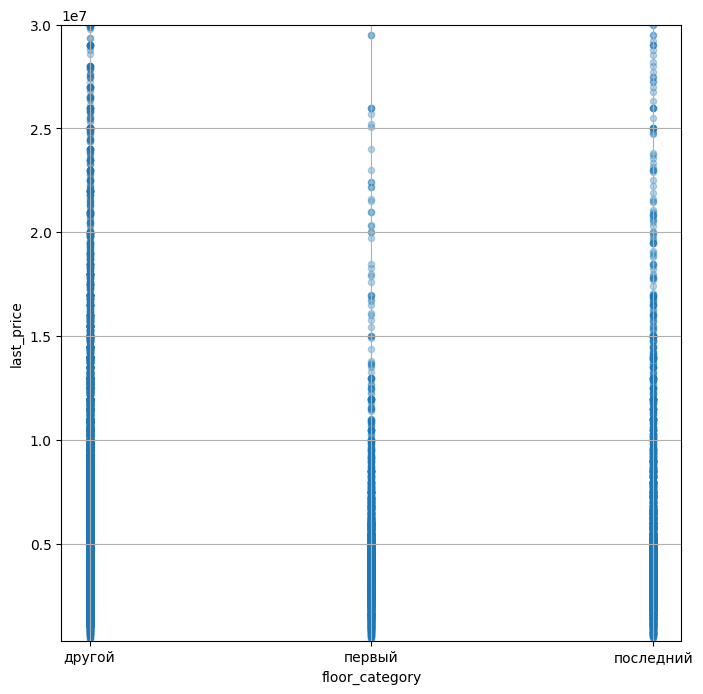

In [150]:
data.plot(x='floor_category',
          y='last_price',
          kind='scatter',
          ylim=(350000, 30000000),
          grid=True,
          alpha=0.3,
          figsize=(8, 8)
         );

Корреляция отсутвует

**Посмотрим на зависимотсть цены от даты размещения объявления**

Построим 3 диаграммы рассеяния, зададим по оси x - дата размещения(день недели, месяц, год), по оси y - цену.

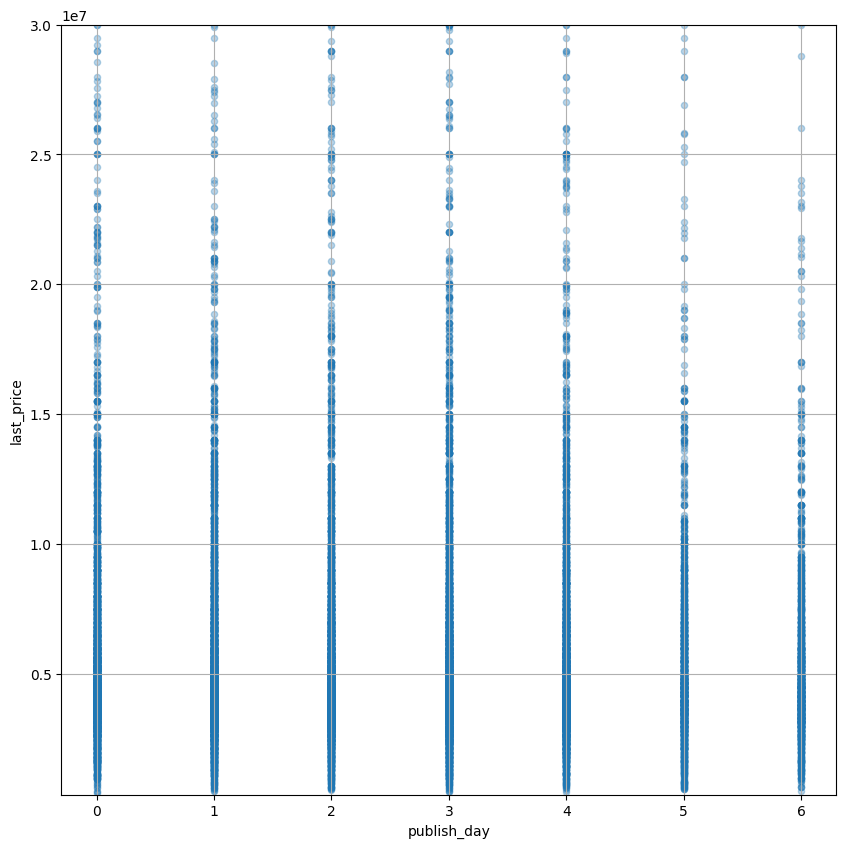

In [151]:
data.plot(x='publish_day',
          y='last_price',
          kind='scatter',
          ylim=(350000, 30000000),
          grid=True,
          alpha=0.3,
          figsize=(10, 10)
         );

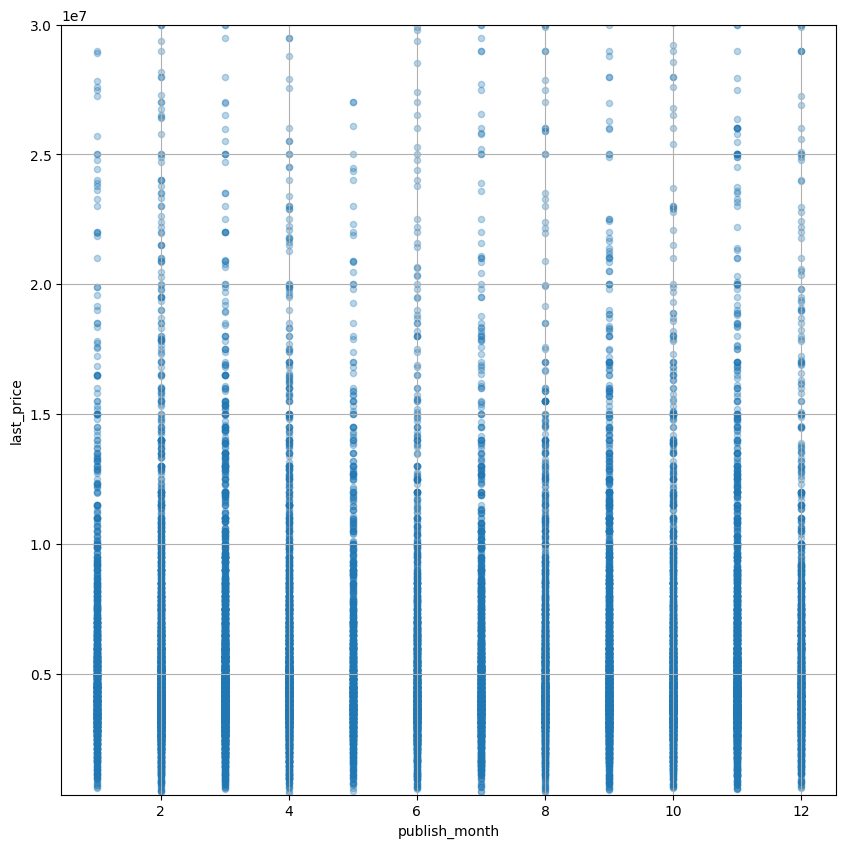

In [152]:
data.plot(x='publish_month',
          y='last_price',
          kind='scatter',
          ylim=(350000, 30000000),
          grid=True,
          alpha=0.3,
          figsize=(10, 10)
         );

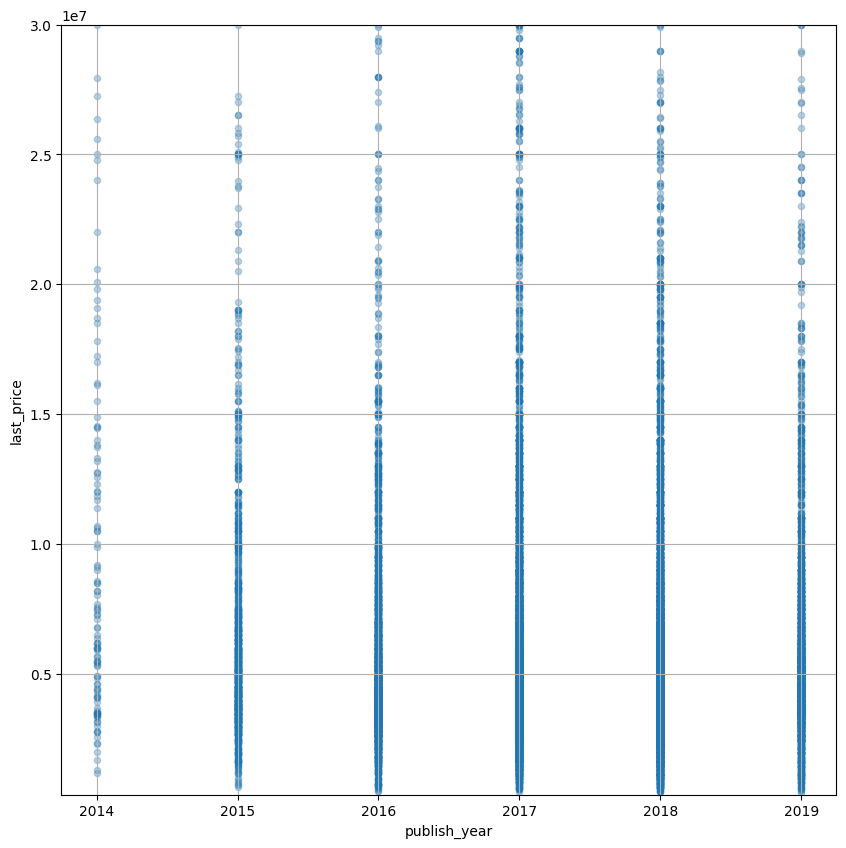

In [153]:
data.plot(x='publish_year',
          y='last_price',
          kind='scatter',
          ylim=(350000, 30000000),
          grid=True,
          alpha=0.3,
          figsize=(10, 10)
         );

Во всех трёх случаях корреляция отсутсвует

**Вывод по факторам влияющим на стоимость объекта**


Проверили гипотезу о влиянии различных параметров на стоимость объёктов. Использовали следующие параметры:
- общую площадь
- жилую площадь
- площадь кухни
- количество комнат
- тип этажа, на котором расположена квартира
- дату размещения (день недели, месяц, год)

В итоге установили что больше всего влияет на цену из перечисленных параметров общая площадь. Жилая площадь и площадь кухни тоже имеют корреляцию, но слабую в особенности площадь кухни.
Остальные параметры никак не повлияли на стоимость объекта.

Гипотеза подтвердилась для одного параметра и частично для двух.

<a id='avg_price_top_towns'></a>
### Средняя цена кв.метра в самых распространённых пунктах

Для начала найдём 10 населённых пункта с большим количествой объявлений

In [154]:
data['locality_name'].value_counts().head(10)

санкт-петербург      13841
мурино                 449
посёлок шушары         390
кудрово                375
всеволожск             357
пушкин                 328
колпино                322
посёлок парголово      287
гатчина                285
петергоф               190
Name: locality_name, dtype: int64

Поместим их в список и создадим датафрейм включающий в себя только те данные где названия совпадают с находящимися в списке.

In [155]:
top_towns = ['санкт-петербург', 'мурино', 'посёлок шушары', 'кудрово', 'всеволожск', 'пушкин', 'колпино',
             'посёлок парголово', 'гатчина', 'петергоф']
top_towns_data = data.query('locality_name == @top_towns')

Посмотрим информацию о новом датафрейме.

In [156]:
top_towns_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16824 entries, 0 to 20625
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          16824 non-null  int64         
 1   last_price            16824 non-null  int64         
 2   total_area            16824 non-null  int64         
 3   first_day_exposition  16824 non-null  datetime64[ns]
 4   rooms                 16824 non-null  int64         
 5   ceiling_height        16824 non-null  float32       
 6   floors_total          16824 non-null  int64         
 7   living_area           16824 non-null  int64         
 8   floor                 16824 non-null  int64         
 9   is_apartment          16824 non-null  bool          
 10  studio                16824 non-null  bool          
 11  open_plan             16824 non-null  bool          
 12  kitchen_area          16824 non-null  int64         
 13  balcony         

Посмотрим названия населённых пунктов в датафрейме что-бы убедится в правильности.

In [157]:
top_towns_data['locality_name'].unique()

array(['санкт-петербург', 'посёлок шушары', 'мурино', 'петергоф',
       'пушкин', 'посёлок парголово', 'кудрово', 'колпино', 'гатчина',
       'всеволожск'], dtype=object)

Сгруппируем даные по городам и высчитаем медиану цены за кв.метр.

In [158]:
top_towns_data.groupby('locality_name').agg(price_median=('price_per_meter', 'median'),
                                           count=('price_per_meter', 'count')) \
                                       .sort_values(by='price_median', ascending=False)

,price_median,count
locality_name,,
санкт-петербург,104545,13841
пушкин,100000,328
кудрово,96226,375
посёлок парголово,92475,287
мурино,85483,449
петергоф,82222,190
посёлок шушары,77355,390
колпино,74861,322
гатчина,67924,285


**Вывод по ср. цене за кв. метр в самых распространённых населённых пунктах**

- Выяснили что самые высокие цены в следующих населённых пунктах: Санкт-Петербург, Пушкин, Кудрово. Медианная цена в них около 100,000р за кв.м.
- Самые низкие из первой 10-ки в: Колпино, Гатчина, Всеволожск. Медианная цена - около 70,000 за кв.метр.

<a id='avg_price_km'></a>
### Средняя цена километра (до центра) в Санкт-Петербурге

Для начала посчитаем стоимость километра и добавим эти значения в новый столбец.

In [159]:
data['price_per_km'] = data['last_price'] / data['centers_nearest_km']

Сделаем срез включающий в себя данные только о Санкт-Петербурге.

In [160]:
spt_data = data.query('locality_name == "санкт-петербург"')
spt_data = spt_data.dropna(subset=['price_per_km']).reset_index(drop=True)
spt_data['centers_nearest_km'] = (spt_data['centers_nearest_km']).astype('int64')
spt_data['price_per_km'] = (spt_data['price_per_km']).astype('int64')

Найдём медиану и среднее в новом столбце.

In [161]:
spt_data['price_per_km'].describe()

count    1.380100e+04
mean     1.160100e+06
std      4.054726e+06
min      8.035700e+04
25%      3.033330e+05
50%      4.333330e+05
75%      9.285710e+05
max      1.650000e+08
Name: price_per_km, dtype: float64

- Медиана - 449664р за км. 
- Среднее - 1425826р за км.

Среднее искажено большим количеством выбросов. Посмотрим на диаграмму рассеяния.

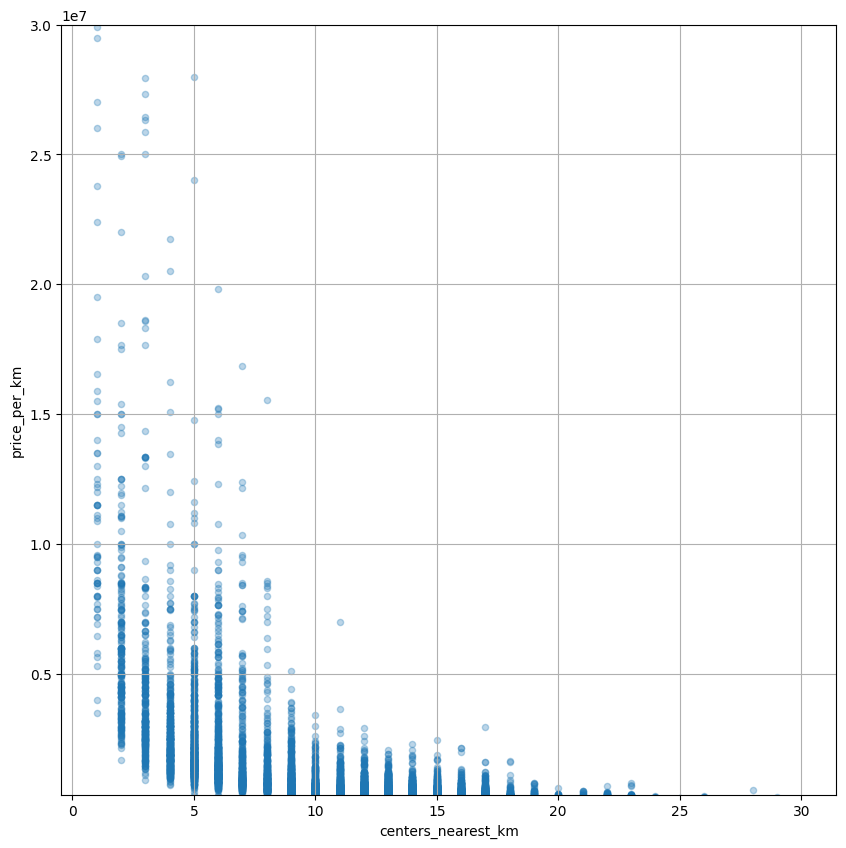

In [162]:
spt_data.plot(x='centers_nearest_km',
              y='price_per_km',
              kind='scatter',
              ylim=(350000, 30000000),
              grid=True,
              alpha=0.3,
              figsize=(10, 10)
             );

Видим что чем дальше от центра тем меньше выбросов по цене и вариативность цен намного меньше чем у объектов близких к центру. Общая тенденция - с ростом растояния от центра, цена падает и снижается её вариативность.

**Вывод по средней цене километра (до центра) в Санкт-Петербурге**

Выянили что среди объёктов бликих к центру очень много выбросов по цене, но даже если их игнорировать, общая цена ненмого выше чем у объектов находящихся дальше от центра. При росте растояния снижается вариативность цены и пропадают выбросы.

<a id='conclusion'></a>
## Выводы

Подготовили полученные данные для исследовательского анализа.
- Избавились от пропущенных данных которые нет возможности восстановить. Произвели заполнение в тех столбцах где была возможность.
- Изменили типы данные в колонках с неправильными типами.
- Обработали дубликаты.
- Выявили и устранили аномалии в данных.
- Добавили новые столбцы, нужные для исследования.

Изучили:
1. **Как быстро продаются квартиры.**
 - Нормальная скорость продажи находится в диапазоне от полтора месяца до полугода
 - Долгие продажи как правило более 200 дней, а те которые больше 500 - необычно долгие.
 - Быстрые продажи можем назвать те которые произошли бестрее чем за месяц


2. **Факторы влияющие на стоимость объекта.**

В качестве факторов взяли следющие параметры:
- общую площадь
- жилую площадь
- площадь кухни
- количество комнат
- тип этажа, на котором расположена квартира
- дату размещения (день недели, месяц, год)

Больше всего на стоимость влияет общая площадь. Жилая и кухни тоже коррелируют со стоимостью, но незначительно. Остальные параметры не влияют или в случае колличества комнат, несущественно влияют.

3. **Среднюю цену квадратного метра в 10 самых распространённых населённых пунктах**
- Самые высокие цены в Санкт-Петербурге, Пушкино, Кудрово.
- Самые низкие в Колпино, Гатчина, Всеволожске.

4. **Среднюю цену километра (до центра) в Санкт-Петербурге**

Выяснили что с увеличением растояния до центра разброс цен сильно уменьшается и полностью пропадают выбросы по цене. У объектов близких к центру огромный разброс по цене, если не учитывать выбросы, то можно увидеть тенденцию падения цены при росте расстояния.